In [2]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, LSTM
from keras.models import Model
from keras.optimizers import Adam
import IPython
import IPython.display
import tensorflow as tf
from tensorflow import keras
from matplotlib import rcParams
from keras.models import Sequential
import scipy
from scipy import io
from scipy.interpolate import interp1d
import os
from sklearn.metrics import accuracy_score, f1_score,mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dropout, Flatten, Dense, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy.io import loadmat
from tqdm import tqdm

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings("ignore")

In [3]:
## ok save mean and std, but min max
def interpolate_signal(insignal, len1, len2):

    first_point = insignal[0]
    last_point = insignal[-1]

    x1 = np.linspace(0, len2 - 1, len1)
    f = interp1d(x1, insignal, axis=0, kind='linear')
    x2 = np.linspace(0, len2 - 1, len2)
    interpolated = f(x2)

    interpolated[0] = first_point
    interpolated[-1] = last_point
    
    return interpolated

def list_to_interpolate_preserving_stats(input_list, output_size=145):
    inter_list = []
    for elem in input_list:
        original_mean = np.nanmean(elem)
        original_std = np.nanstd(elem)

        np_int = interpolate_signal(elem, elem.shape[0], output_size)

        central_part = np_int[1:-1]

        interpolated_mean = np.nanmean(central_part)
        interpolated_std = np.nanstd(central_part)

        scaled_central = (central_part - interpolated_mean) * (original_std / interpolated_std) + original_mean

        scaled_int = np.copy(np_int)
        scaled_int[1:-1] = scaled_central

        total_mean = np.nanmean(scaled_int)
        total_std = np.nanstd(scaled_int)
        scaled_int = (scaled_int - total_mean) * (original_std / total_std) + original_mean

        scaled_int[0] = elem[0]
        scaled_int[-1] = elem[-1]
        inter_list.append(scaled_int)
    
    return inter_list

def scaled_data2(input_list):

    global_min = np.nanmin([np.nanmin(traj) for traj in input_list])
    global_max = np.nanmax([np.nanmax(traj) for traj in input_list])

    if global_max == global_min:
        raise ValueError("All trajectories have the same constant value; scaling is not possible.")
    
    normalized_list = []

    for np_array in input_list:
        output_array = 2 * ((np_array - global_min) / (global_max - global_min)) - 1

        #output_array -= output_array[0]

        #range_factor = max(1, np.max(np.abs(output_array)))
        #output_array /= range_factor

        normalized_list.append(output_array)

    return normalized_list, global_max, global_min

In [7]:
def load_data():
    # Load data
    data = scipy.io.loadmat('../data/trajectories.mat')
    
    # Path
    iid = data['iidind'][2:,]
    rdw = data['rdwind'][2:,]
    posr = np.zeros((iid.shape[0] - 1, iid.shape[1]))
    posw = np.zeros((rdw.shape[0]-1, rdw.shape[1]))
    n_path = posr.shape[1]
    invis = []
    normativ_label_iid = np.zeros((1, n_path))  # ideal responses
    normativ_label_rdw = np.zeros((1, n_path))  # ideal responses
    for tidx in range(n_path):
        # IID
        invisR = int(iid[0, tidx])
        invis.append(invisR)
        r = iid[1:, tidx].copy()
        #r[-invisR + 1:] = np.nan
        r[-invisR + 1:] = 0
        posr[:, tidx] = r
        normativ_label_iid[0, tidx] = 1 if np.nanmean(posr[:, tidx]) < 0 else 0
        # rdw 
        w = rdw[1:, tidx].copy()
        #w[-invisR+1:] = np.nan
        w[-invisR+1:] = 0
        posw[:, tidx] = w
        normativ_label_rdw[0, tidx] = 1 if posw[-invis[tidx], tidx] < 0 else 0
    
    # # Create a list of columns from posr without NaN values
    # path_iid = [np.array(col[~np.isnan(col)]) for col in posr.T]
    
    # # Create a list of columns from posw without NaN values
    # path_rdw = [np.array(col[~np.isnan(col)]) for col in posw.T]
    normativ_label_rdw =normativ_label_rdw.reshape(200,)
    normativ_label_iid =normativ_label_iid.reshape(200,)
    
    ### rdw ###
    normativ_label_rdw_same = np.hstack((normativ_label_rdw[0:50], normativ_label_rdw[150:]))
    normativ_label_rdw_op = normativ_label_rdw[50:150]
    normativ_list_label_rdw_same = [np.array(col[~np.isnan(col)]) for col in normativ_label_rdw_same]
    normativ_list_label_rdw_op = [np.array(col[~np.isnan(col)]) for col in normativ_label_rdw_op]
    normativ_labels_r = np.concatenate((normativ_list_label_rdw_same, normativ_list_label_rdw_op ), axis=0)

    posw_same = np.hstack((posw[:,0:50], posw[:,150:]))
    posw_opposite = posw[:,50:150]
    # Create a list of columns from posr without NaN values
    path_rdw_s = [np.array(col[~np.isnan(col)]) for col in posw_same.T]
    path_rdw_op =[np.array(col[~np.isnan(col)]) for col in posw_opposite.T]

    ### iid ###
    normativ_label_iid_same = np.hstack((normativ_label_iid[0:50], normativ_label_iid[150:]))
    normativ_label_iid_op = normativ_label_iid[50:150]
    normativ_list_label_iid_same = [np.array(col[~np.isnan(col)]) for col in normativ_label_iid_same]
    normativ_list_label_iid_op = [np.array(col[~np.isnan(col)]) for col in normativ_label_iid_op]
    normativ_labels_i = np.concatenate((normativ_list_label_iid_same, normativ_list_label_iid_op ), axis=0)

    posr_same = np.hstack((posr[:,0:50], posr[:,150:]))
    posr_opposite = posr[:,50:150]
    # Create a list of columns from posr without NaN values
    path_iid_s = [np.array(col[~np.isnan(col)]) for col in posr_same.T]
    path_iid_op =[np.array(col[~np.isnan(col)]) for col in posr_opposite.T]    
    
    return path_iid_s, path_iid_op, path_rdw_s, path_rdw_op


def interpolate_signal(insignal, len1, len2):

    first_point = insignal[0]
    last_point = insignal[-1]

    x1 = np.linspace(0, len2 - 1, len1)
    f = interp1d(x1, insignal, axis=0, kind='linear')
    x2 = np.linspace(0, len2 - 1, len2)
    interpolated = f(x2)

    interpolated[0] = first_point
    interpolated[-1] = last_point
    
    return interpolated

def list_to_interpolate_preserving_stats(input_list, output_size=145):
    inter_list = []
    for elem in input_list:
        np_int = interpolate_signal(elem, elem.shape[0], output_size)
        inter_list.append(np_int)
    return inter_list

def scaled_data2(input_list):

    global_min = np.nanmin([np.nanmin(traj) for traj in input_list])
    global_max = np.nanmax([np.nanmax(traj) for traj in input_list])

    if global_max == global_min:
        raise ValueError("All trajectories have the same constant value; scaling is not possible.")
    
    normalized_list = []

    for np_array in input_list:
        output_array = 2 * ((np_array - global_min) / (global_max - global_min)) - 1

        #output_array -= output_array[0]

        #range_factor = max(1, np.max(np.abs(output_array)))
        #output_array /= range_factor

        normalized_list.append(output_array)

    return normalized_list, global_max, global_min

def load_responses(resp_array):
    resp_same =  np.vstack((resp_array[0:50:,], resp_array[150::,]))
    resp_op = resp_array[50:150:,]
    return resp_same,resp_op


def shuffle_data(trajectories, responses,rt):
    indices = np.arange(len(trajectories))  
    np.random.seed(15)
    np.random.shuffle(indices)  
    
    shuffled_trajectories = [trajectories[i] for i in indices]  
    shuffled_responses = responses[indices,: ]  
    shuffled_rt = rt[indices,: ]      
    return shuffled_trajectories, shuffled_responses,shuffled_rt 

def make_dataset (path_iid_s,path_iid_op, resp_iid_s,resp_iid_op,rt_iid_s,rt_iid_op):
    feature_list =[]
    label_list = []
    rt_list=[]
    for i in range(resp_iid_s.shape[1]):
        resp_one_subj_iid_s = resp_iid_s[:, i]
        resp_one_subj_iid_op = resp_iid_op[:, i]
        
        rt_one_subj_iid_s = rt_iid_s[:, i]
        rt_one_subj_iid_op = rt_iid_op[:, i]  
        
        resp_list_iid_s = [np.array(col[~np.isnan(col)]) for col in resp_one_subj_iid_s]
        resp_list_iid_op = [np.array(col[~np.isnan(col)]) for col in resp_one_subj_iid_op]

        rt_list_iid_s = [col[col != 0] for col in rt_one_subj_iid_s]
        rt_list_iid_op = [col[col != 0] for col in rt_one_subj_iid_op]

        scaled_data = np.concatenate((path_iid_s, path_iid_op), axis=0)
        labels = np.concatenate((resp_list_iid_s, resp_list_iid_op), axis=0)
       
        rts = np.concatenate((rt_list_iid_s, rt_list_iid_op), axis=0)

        feature_list.append(scaled_data)
        label_list.append(labels)
        rt_list.append(rts)
    return feature_list, label_list,rt_list

In [8]:
def shuffle_dataset(feature_list, label_list,rt_list, condition):
    combined_data = list(zip(feature_list, label_list, rt_list)) # Combine features and labels into a single list for shuffling
    np.random.seed(10)
    np.random.shuffle(combined_data) # Shuffle the combined data
    feature_list, label_list, rt_list = zip(*combined_data) # Unpack the shuffled data back into features and labels
    feature_list = list(feature_list) # Convert the shuffled lists back to regular Python lists
    label_list = list(label_list)
    rt_list = list(rt_list)
    
    norm_list= []
    # norm rdw 
    if condition=="rdw":
        norm_list.extend([np.where(feature_list[0][:,-1] > 0, 0, 1)] * 28)    
    elif condition=="iid":
    #norm iid 
        norm_list.extend([np.where(np.mean(feature_list[0].T, axis=0) > 0, 0, 1)] * 28)
    
    X = np.concatenate([f.reshape(f.shape[0], -1) for f in feature_list], axis=0)    
    y = np.concatenate(label_list, axis=0)
    rt = np.concatenate(rt_list, axis=0)
    
    norm = np.array(norm_list)
    all_y = np.concatenate([y[i].reshape(-1) for i in range(len(y))], axis=0)
    all_rt = np.concatenate([rt[i].reshape(-1) for i in range(len(rt))], axis=0)
    all_norm = np.concatenate([norm[i].reshape(-1) for i in range(len(norm))], axis=0)
    # X.shape, y.shape,all_y.shape, all_norm.shape
    return X,all_y,all_rt,all_norm


def remove_nan_indices(X, y, rt):
   
    #X = np.array(X)
    #y = np.array(y)
    #rt = np.array(rt)

    valid_indices = ~np.isnan(rt)
    X_clean = X[valid_indices]
    y_clean = y[valid_indices]
    rt_clean = rt[valid_indices]

    return X_clean, y_clean, rt_clean

def create_recent_points_data(X, y, rt, window_size):
    X_windows = []
    y_windows = []
    rt_windows = []
    
    for i in range(X.shape[0]):  
        trajectory = X[i]
        label = y[i]
        rt_value = rt[i]
        invis = len(np.where(trajectory == 0)[0])-1
        trajectory_non_zero = trajectory[:-invis]
        # last point in window_size 
        window = trajectory_non_zero[-window_size:]
        X_windows.append(window)
        y_windows.append(label)
        rt_windows.append(rt_value)
    
    return np.array(X_windows), np.array(y_windows), np.array(rt_windows)



In [9]:
path_iid_s, path_iid_op, path_rdw_s, path_rdw_op = load_data()


rt_rdw = pd.read_csv('../data/pros_rt_rdw.csv', header=None).to_numpy()
rt_iid = pd.read_csv('../data/pros_rt_iid.csv', header=None).to_numpy()
resp_rdw = pd.read_csv('../data/resp_rdw.csv', header=None).to_numpy()
resp_iid = pd.read_csv('../data/esp_iid.csv', header=None).to_numpy()

acc_rdw = pd.read_csv('../data/acc_rdw.csv', header=None).to_numpy()
acc_iid = pd.read_csv('../data/acc_iid.csv', header=None).to_numpy()

resp_iid_same,resp_iid_op= load_responses(resp_iid)
resp_rdw_same,resp_rdw_op= load_responses(resp_rdw)

rt_iid_same,rt_iid_op= load_responses(rt_iid)
rt_rdw_same,rt_rdw_op= load_responses(rt_rdw)

norm_acc_iid_same,norm_acc_iid_op = load_responses(acc_iid)
norm_acc_rdw_same,norm_acc_rdw_op = load_responses(acc_rdw)


In [10]:
######### IID ##########
##interpolation 
path_iid_same_interp_list = list_to_interpolate_preserving_stats(path_iid_s, output_size=150)
path_iid_op_interp_list = list_to_interpolate_preserving_stats(path_iid_op, output_size=150)
# Normalization
scaled_list_iid_same, _, _,  = scaled_data2(path_iid_same_interp_list)  # Transpose for correct shape
scaled_list_iid_op, _, _,  = scaled_data2(path_iid_op_interp_list)  # Transpose for correct shape

######### RDW ##########
##interpolation 
path_rdw_same_interp_list = list_to_interpolate_preserving_stats(path_rdw_s, output_size=150)
path_rdw_op_interp_list = list_to_interpolate_preserving_stats(path_rdw_op, output_size=150)
## Normalization
scaled_list_rdw_same, _, _,  = scaled_data2(path_rdw_same_interp_list)  # Transpose for correct shape
scaled_list_rdw_op, _, _,  = scaled_data2(path_rdw_op_interp_list)  # Transpose for correct shape

In [11]:
scaled_list_iid_same, resp_iid_same,rt_iid_same = shuffle_data(scaled_list_iid_same, resp_iid_same,rt_iid_same)
scaled_list_iid_op, resp_iid_op, rt_iid_op = shuffle_data(scaled_list_iid_op, resp_iid_op,rt_iid_op)

scaled_list_rdw_same, resp_rdw_same,rt_rdw_same = shuffle_data(scaled_list_rdw_same, resp_rdw_same,rt_rdw_same)
scaled_list_rdw_op, resp_rdw_op,rt_rdw_op = shuffle_data(scaled_list_rdw_op, resp_rdw_op,rt_rdw_op)

feature_list_iid, label_list_iid,rt_list_iid = make_dataset(scaled_list_iid_same,scaled_list_iid_op, 
                                                        resp_iid_same,resp_iid_op,rt_iid_same, rt_iid_op)

feature_list_rdw, label_list_rdw,rt_list_rdw = make_dataset (scaled_list_rdw_same,scaled_list_rdw_op,
                                                             resp_rdw_same,resp_rdw_op,rt_rdw_same, rt_rdw_op)

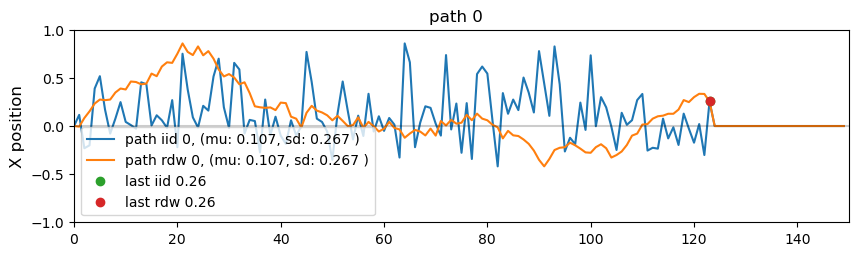

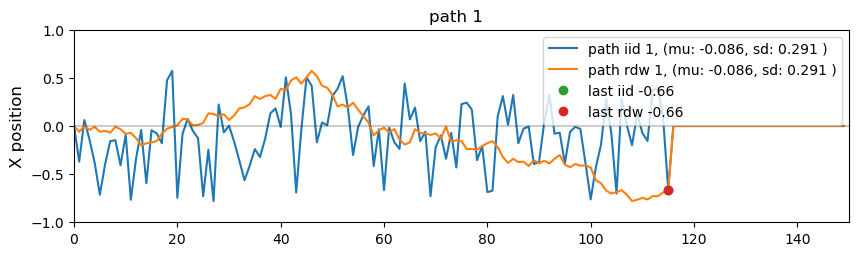

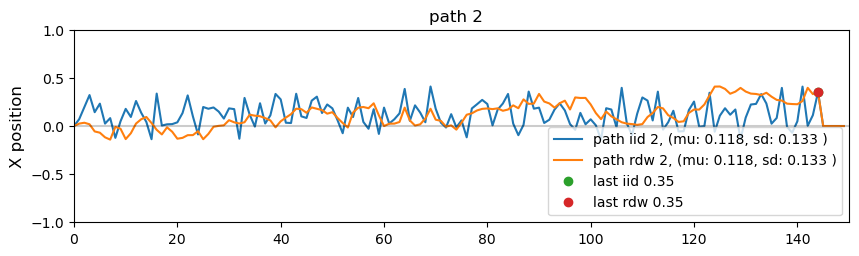

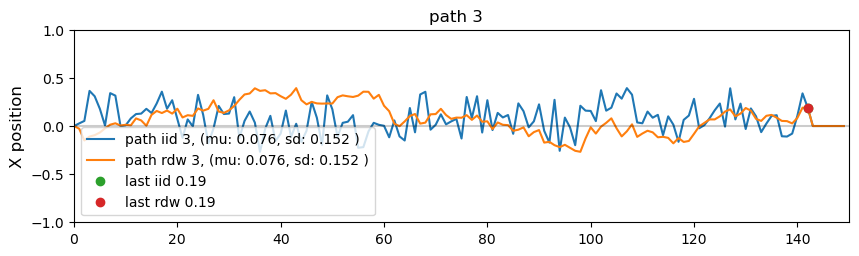

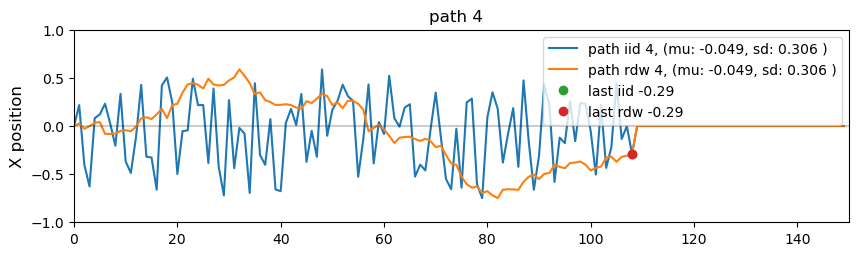

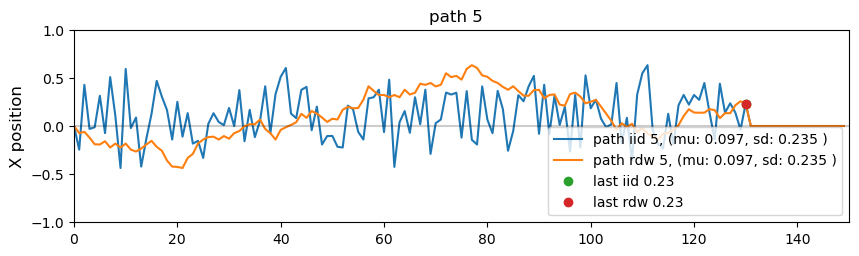

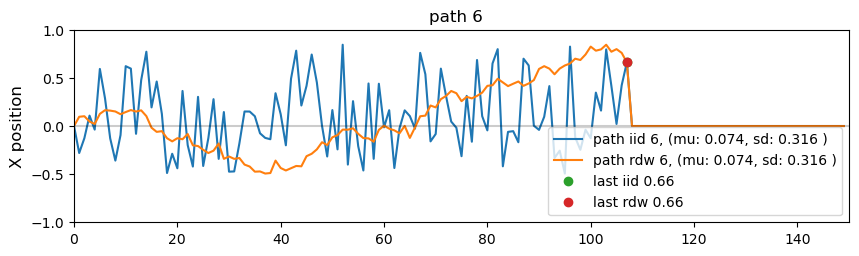

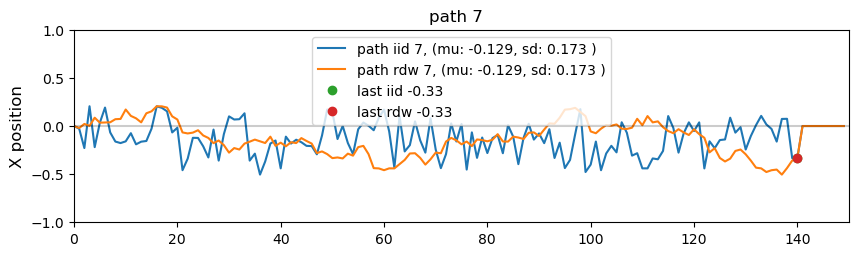

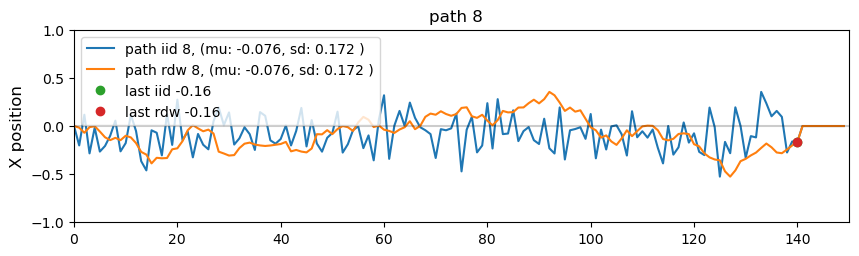

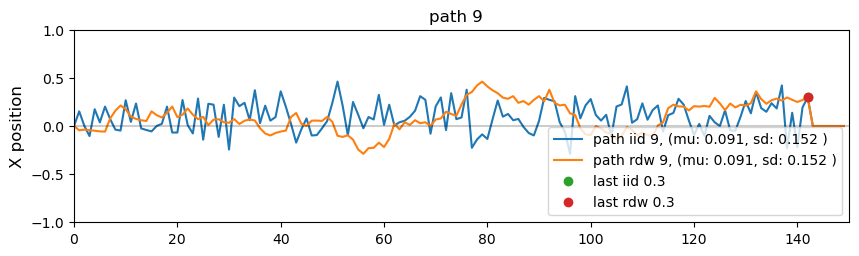

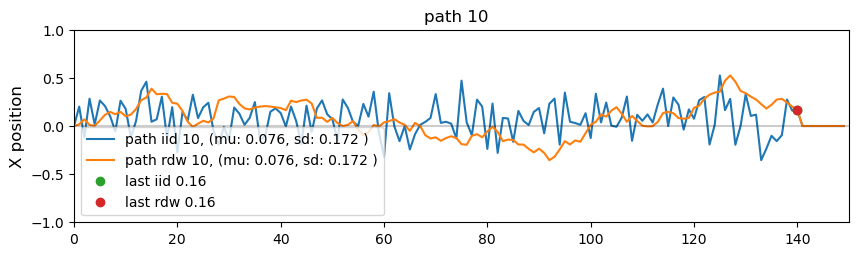

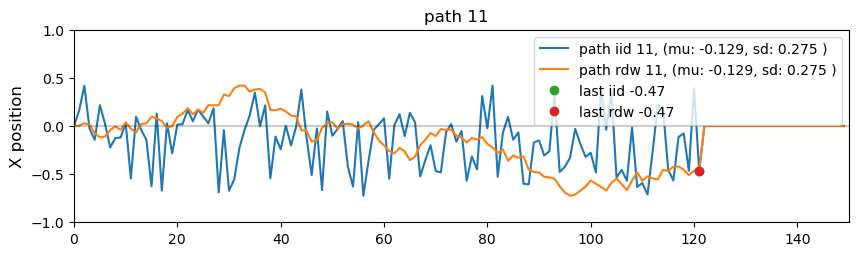

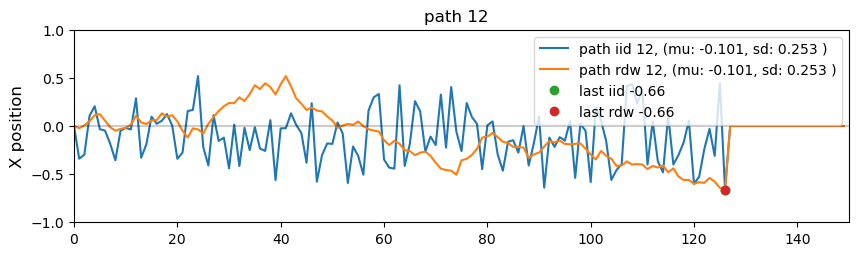

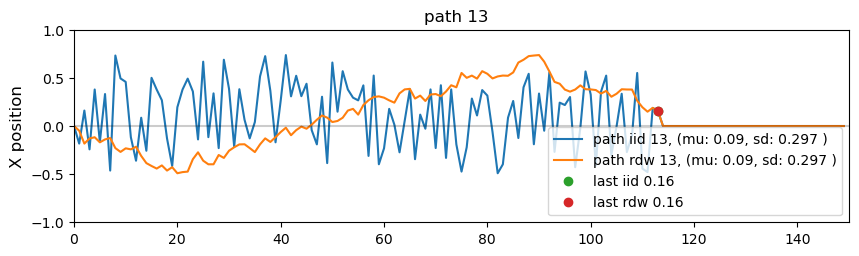

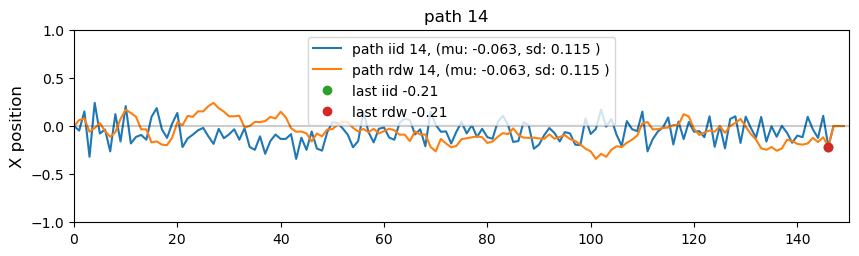

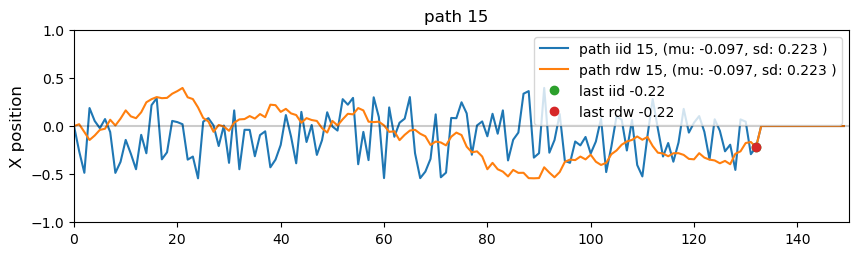

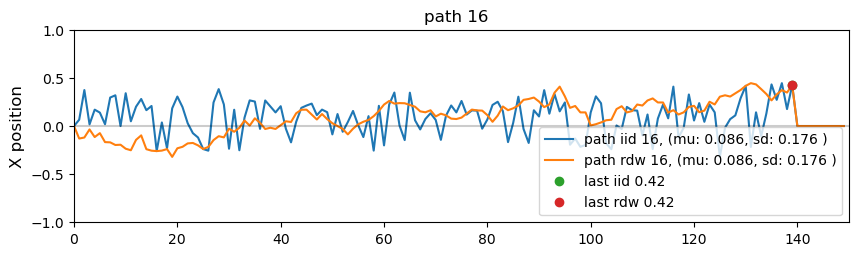

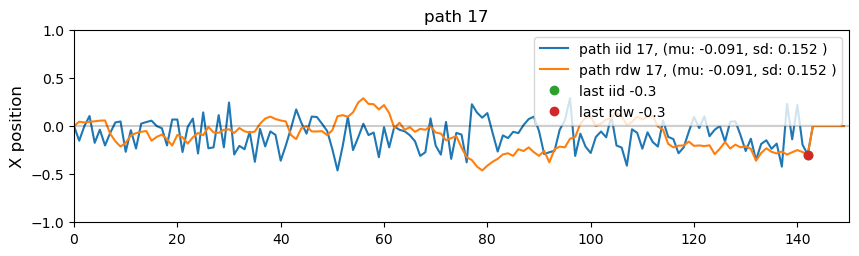

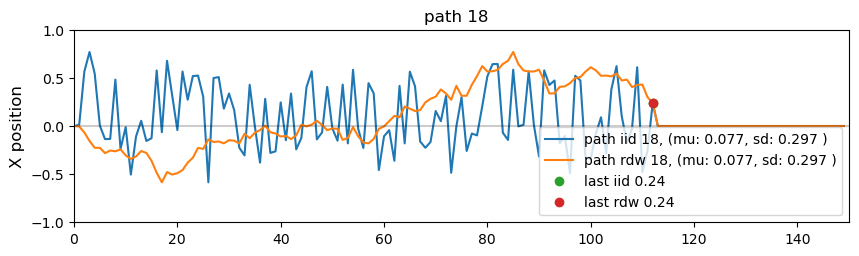

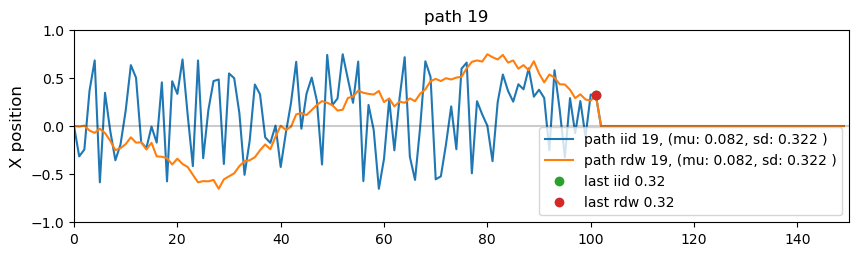

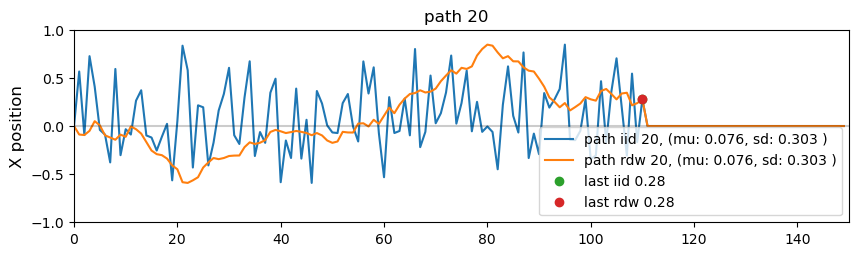

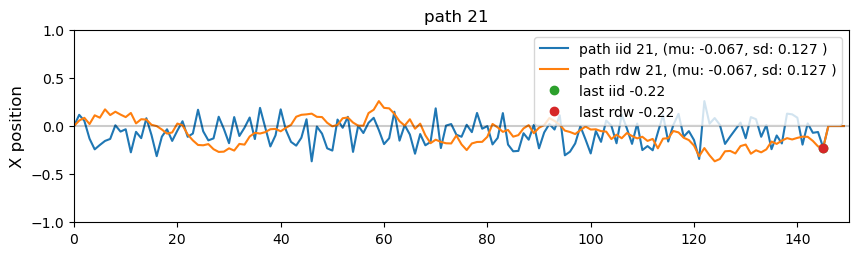

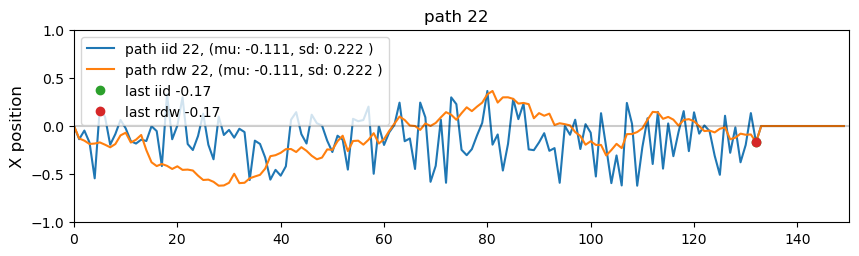

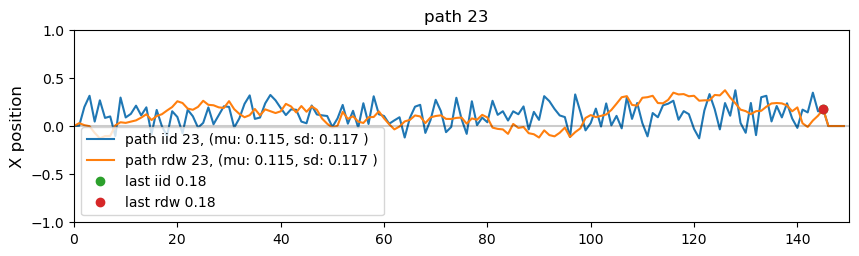

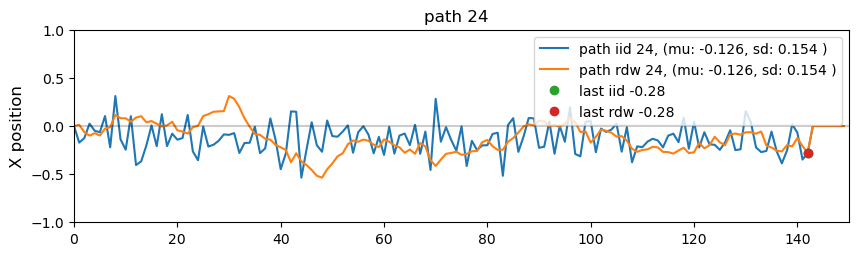

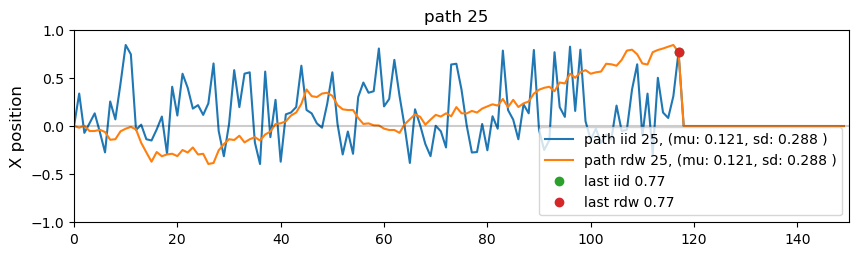

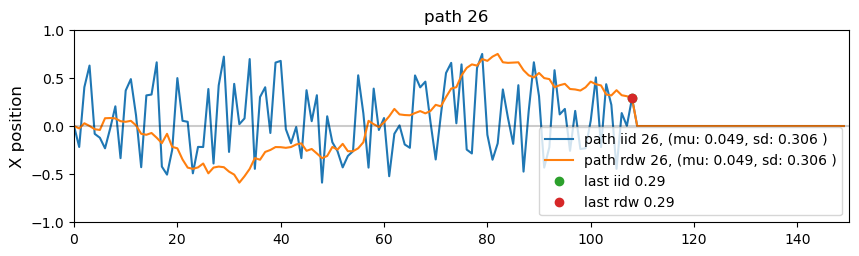

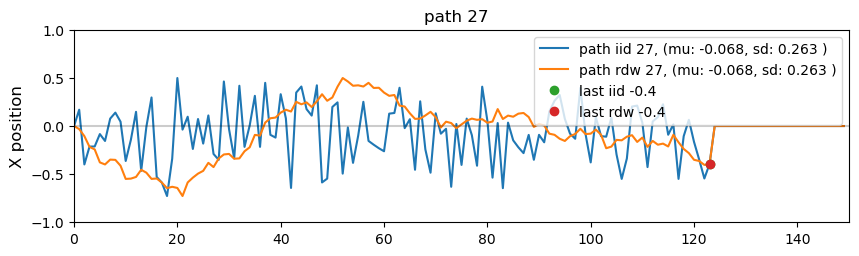

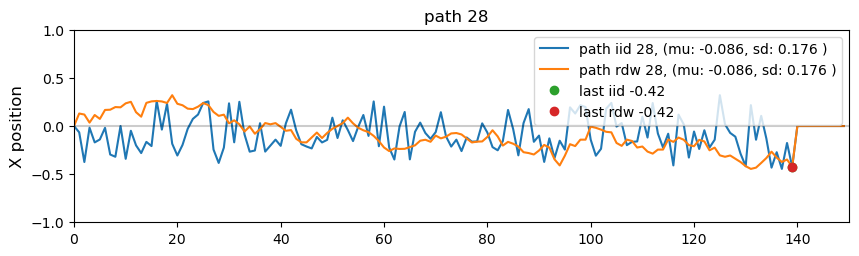

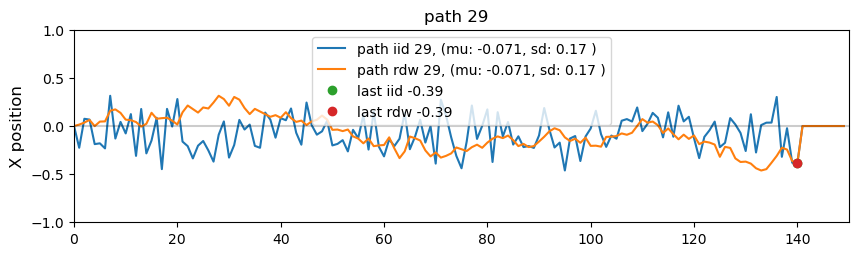

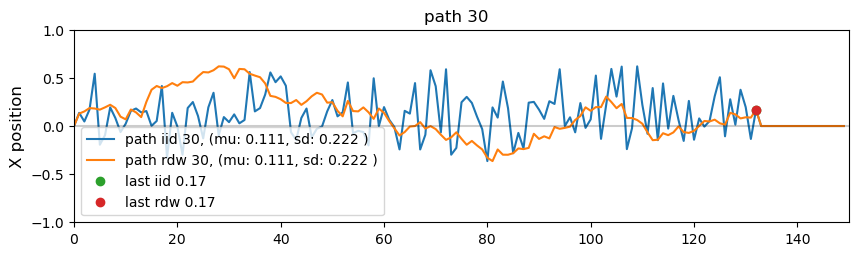

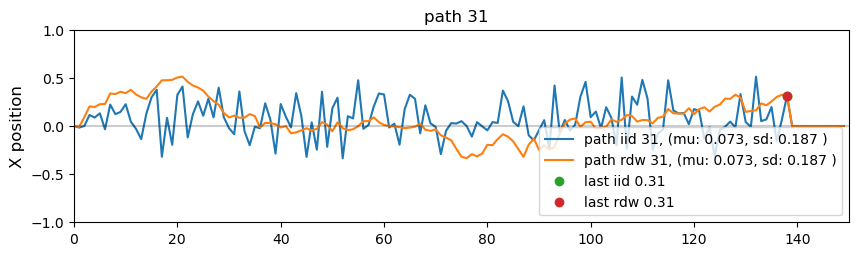

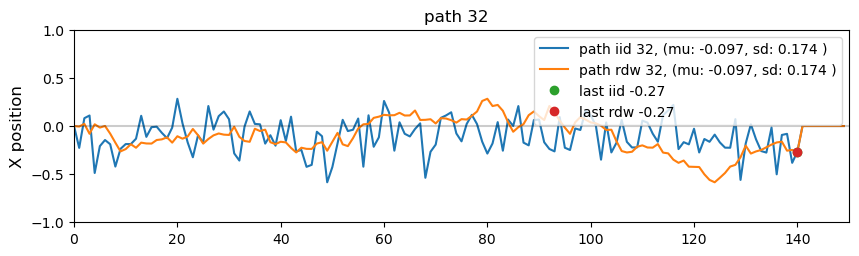

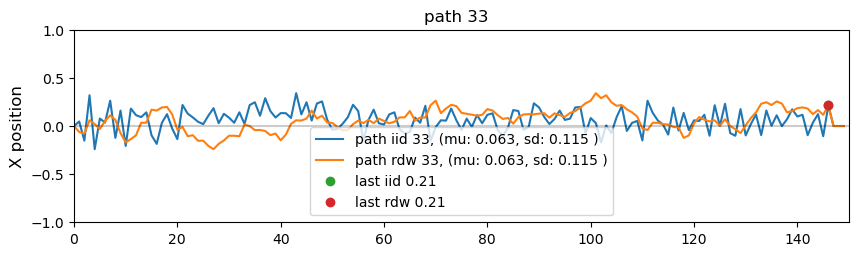

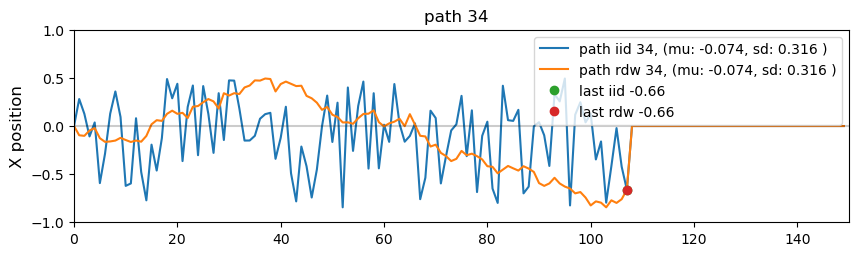

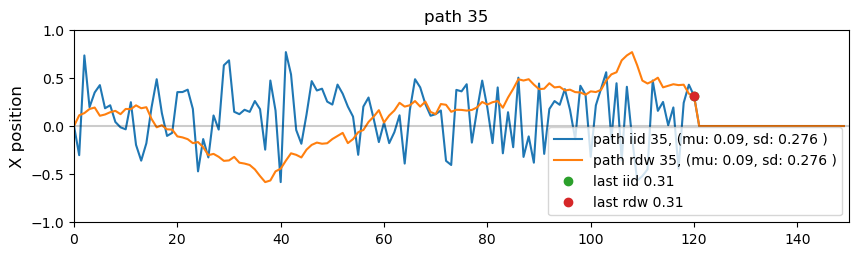

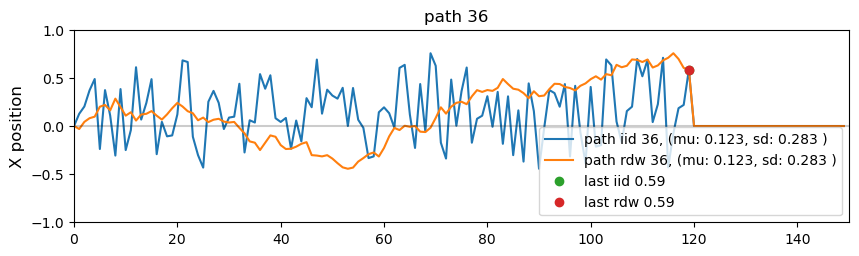

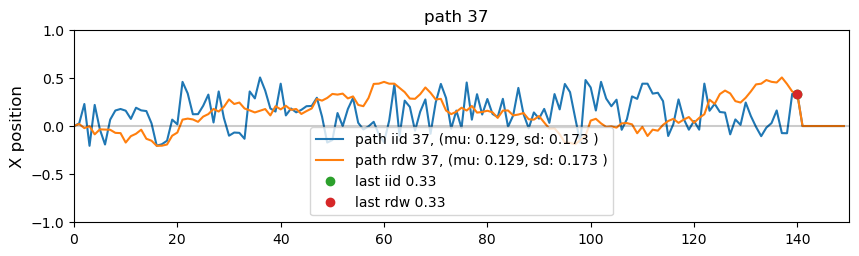

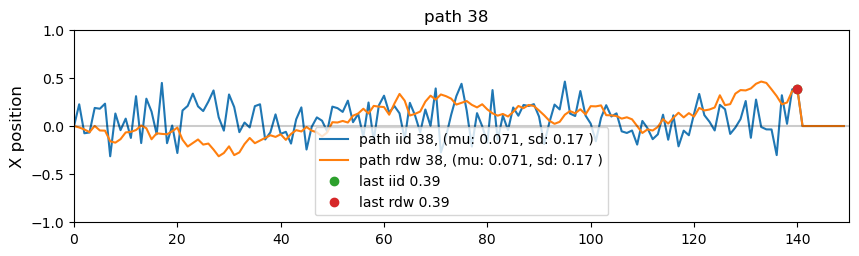

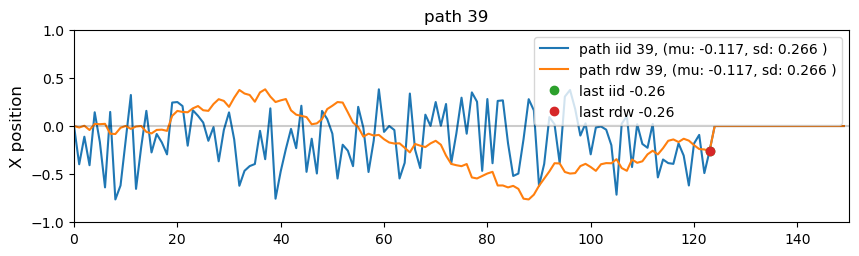

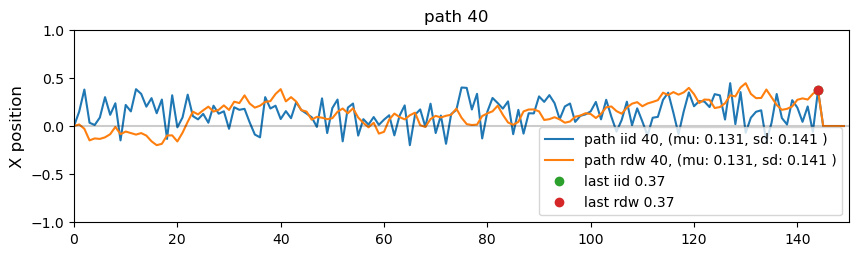

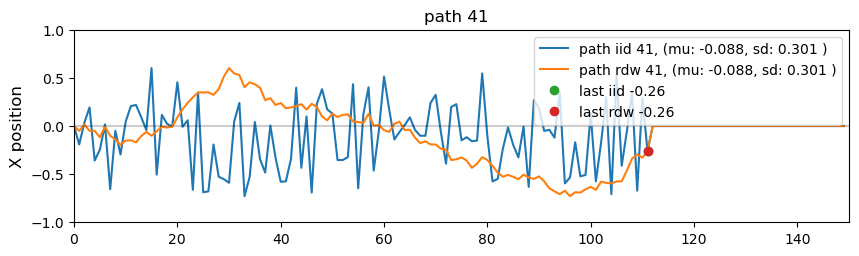

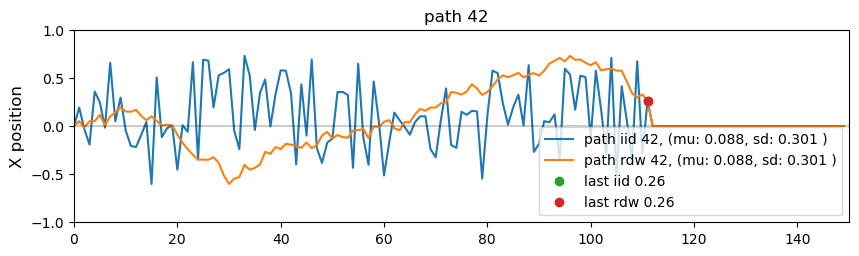

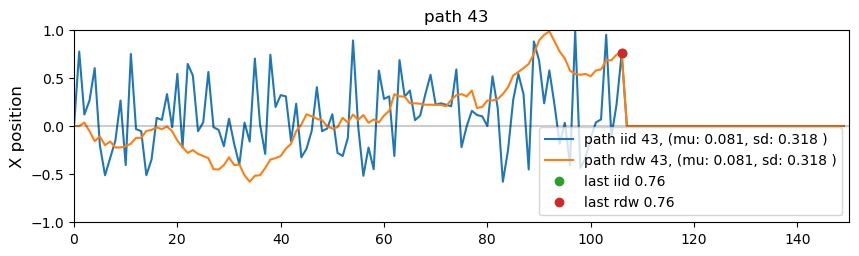

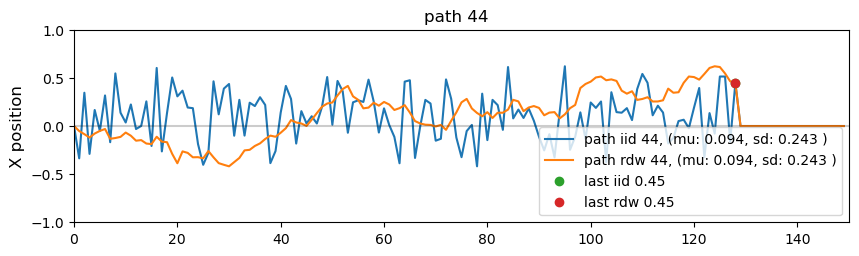

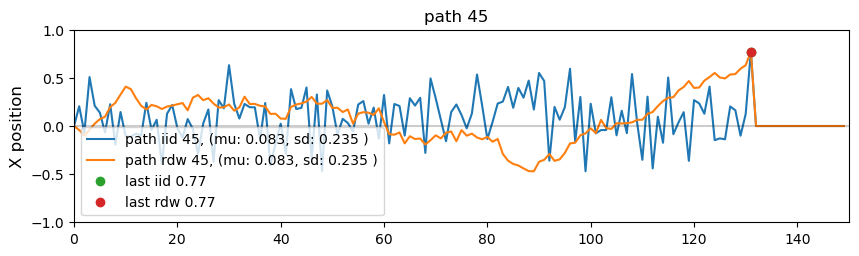

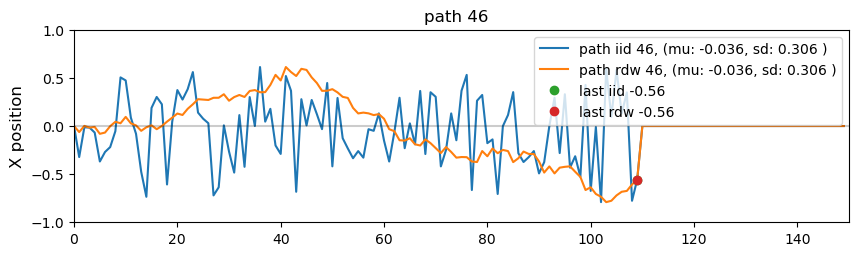

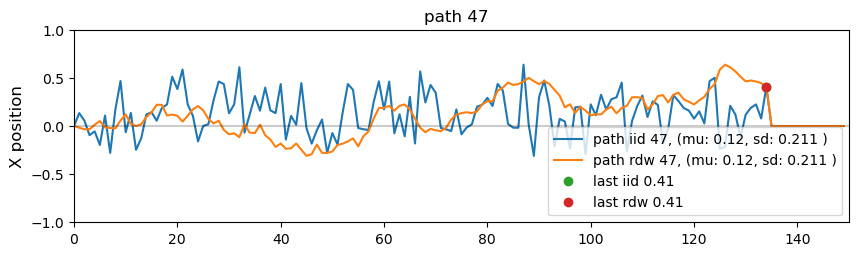

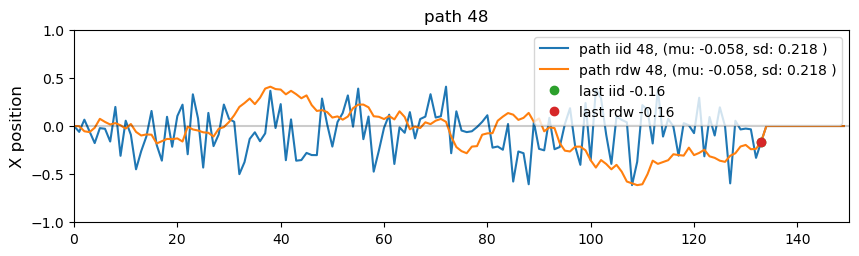

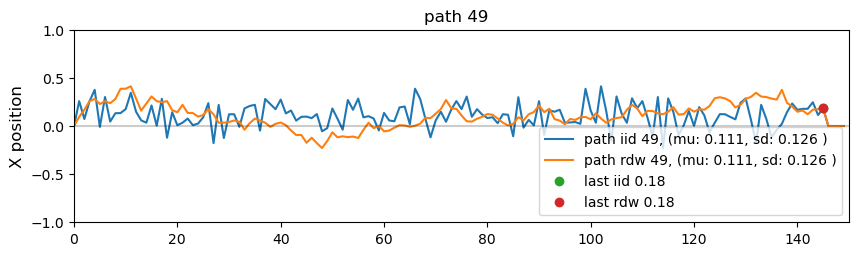

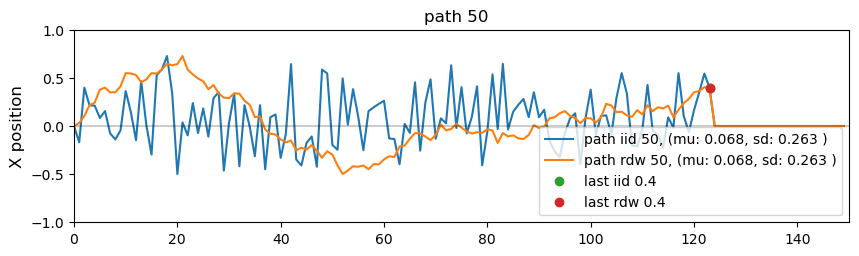

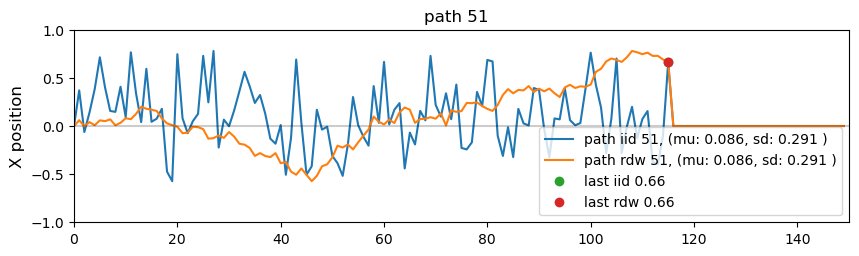

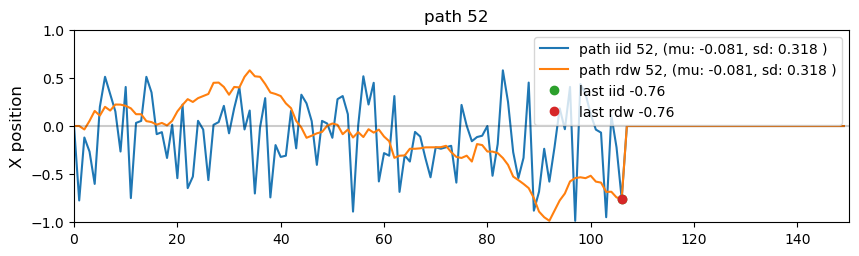

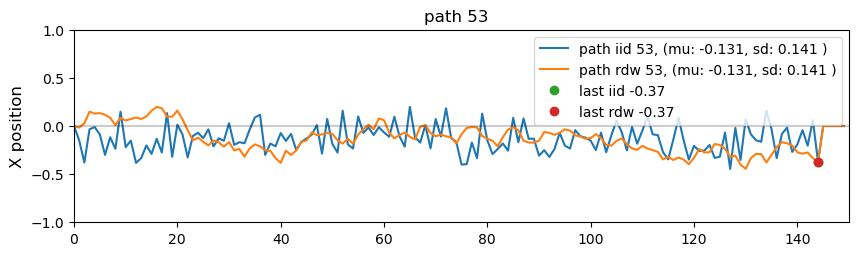

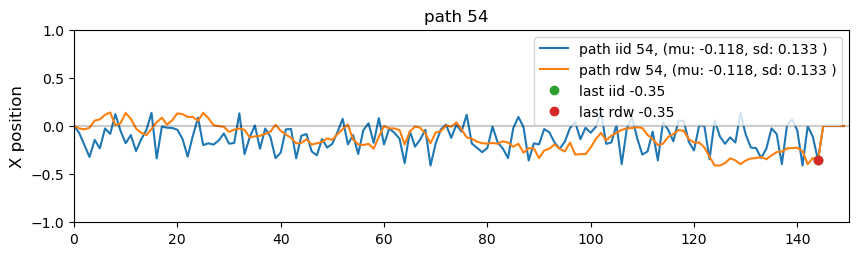

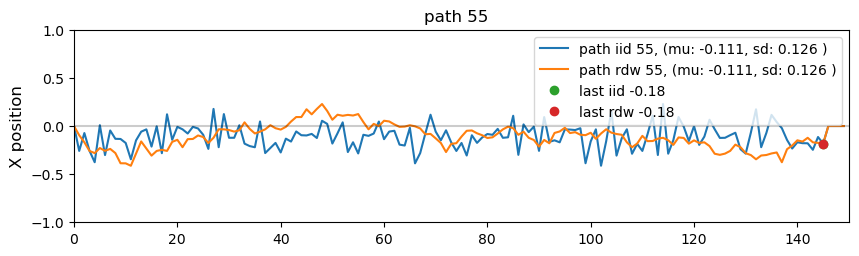

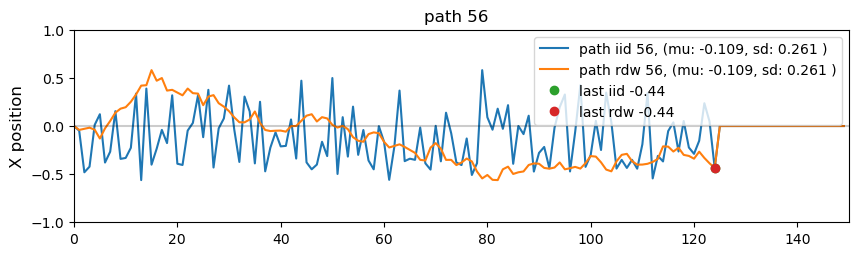

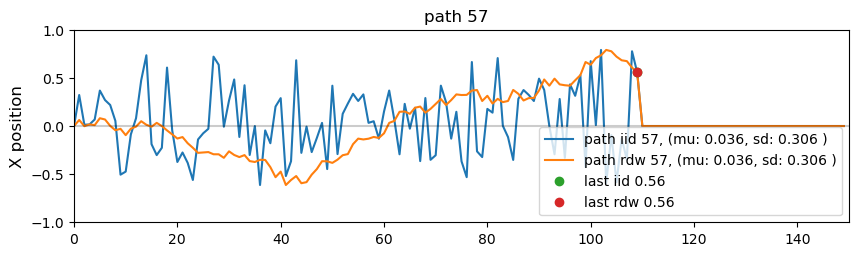

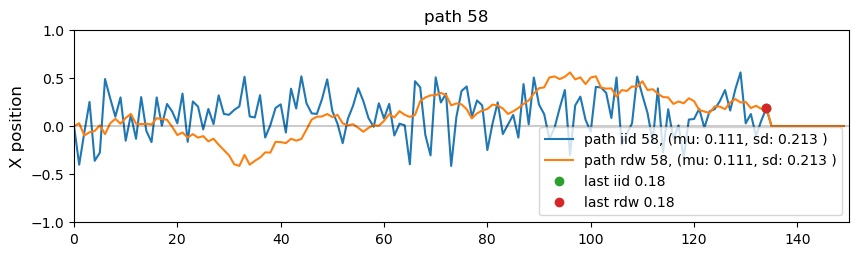

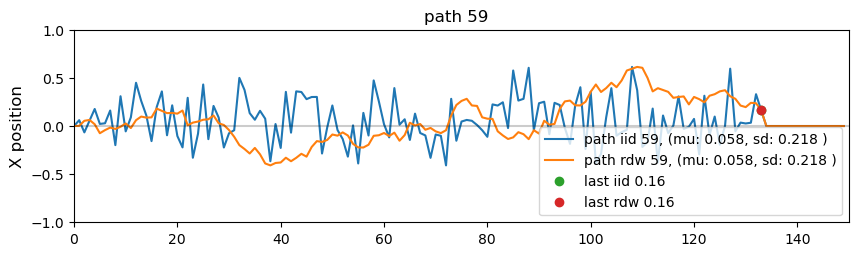

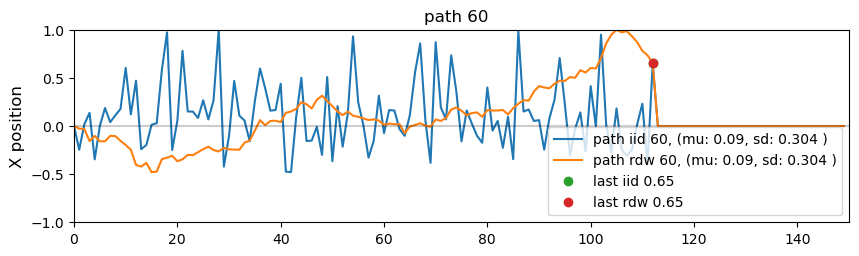

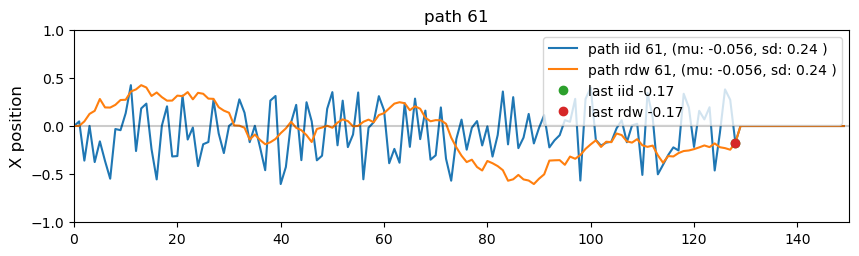

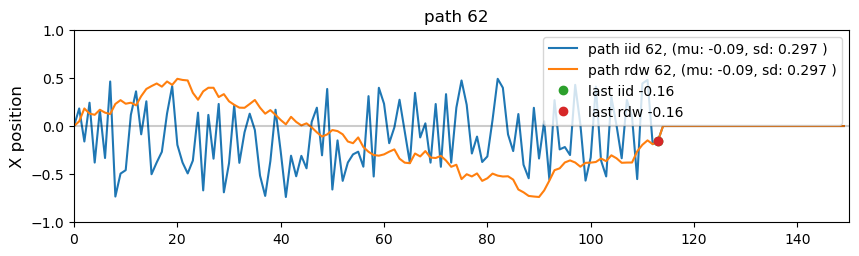

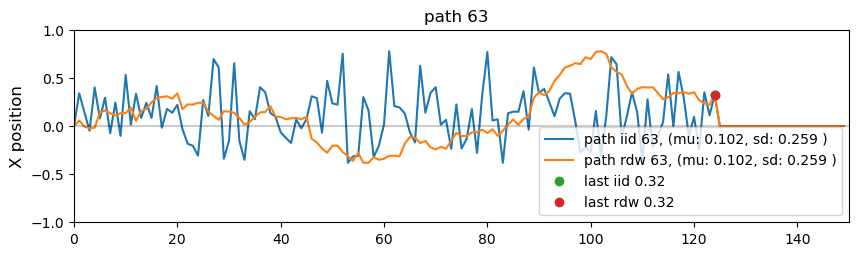

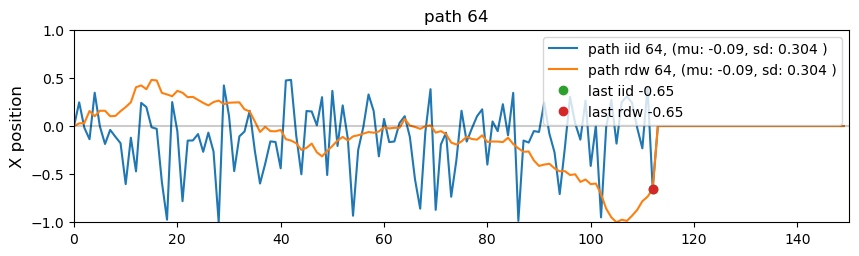

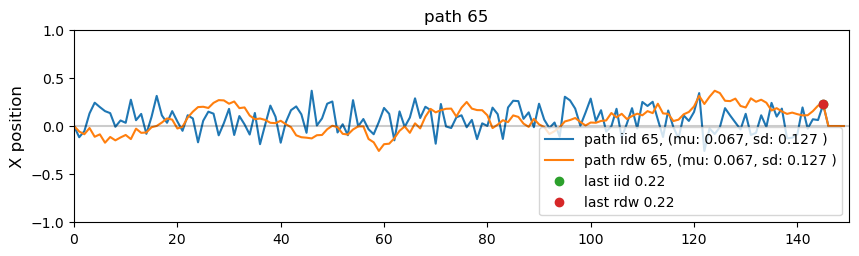

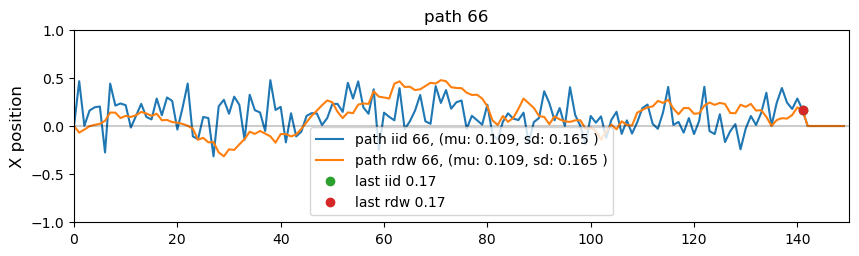

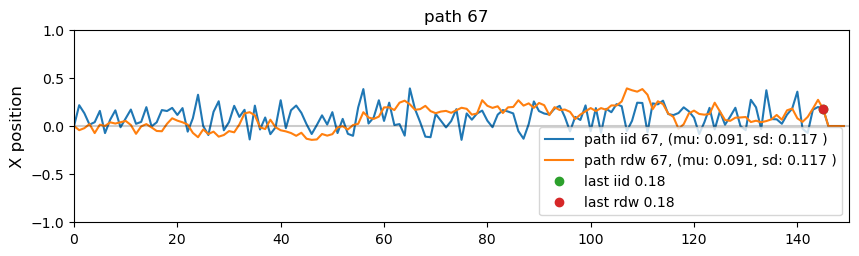

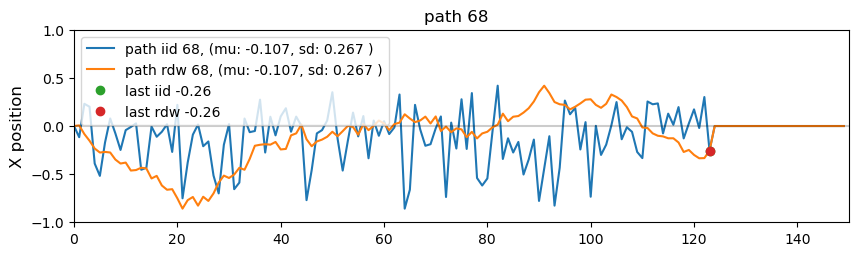

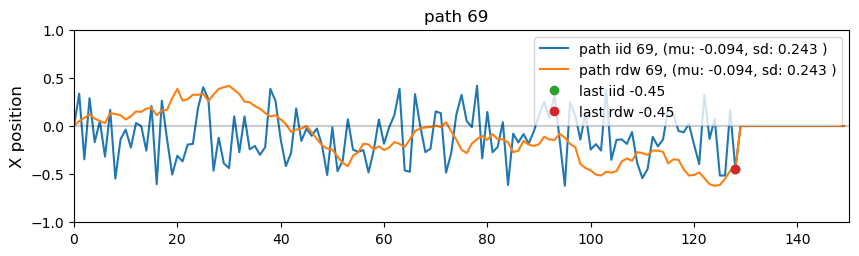

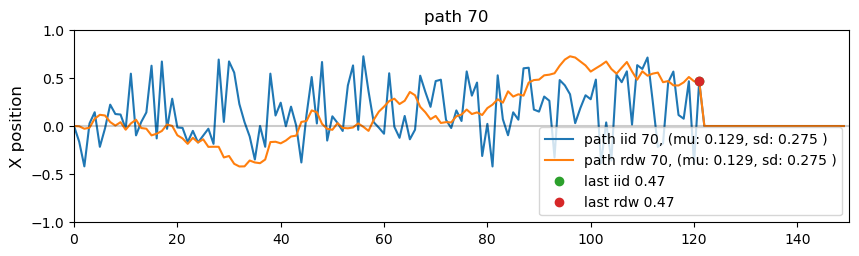

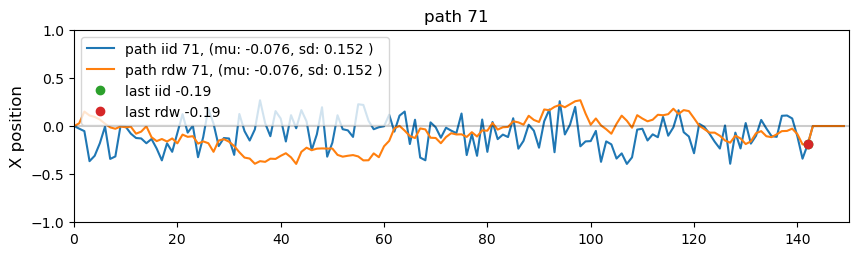

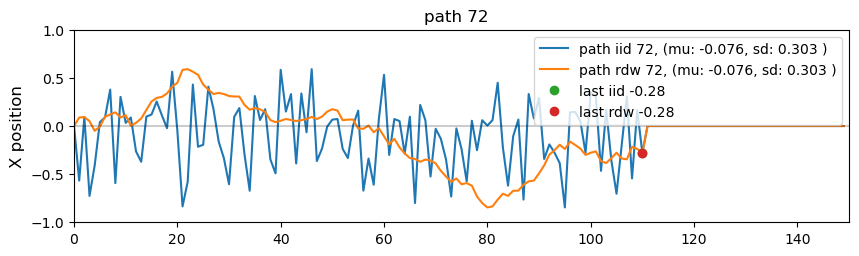

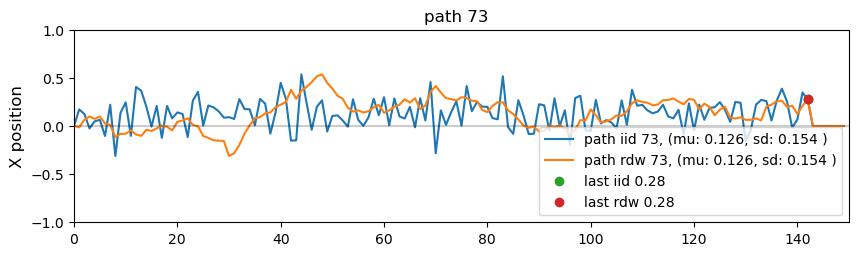

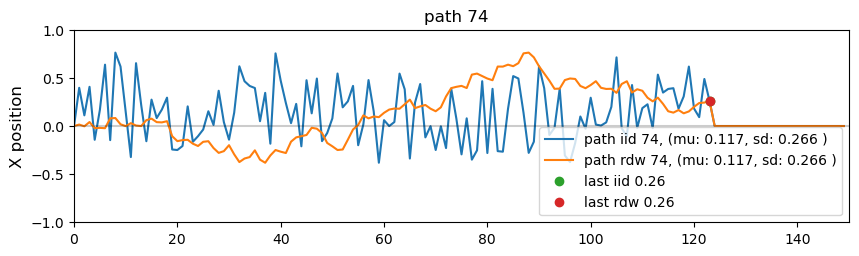

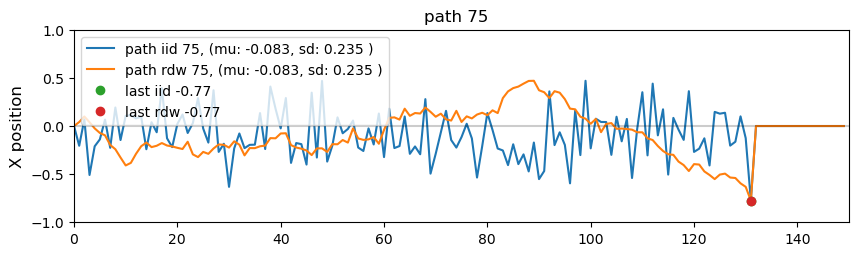

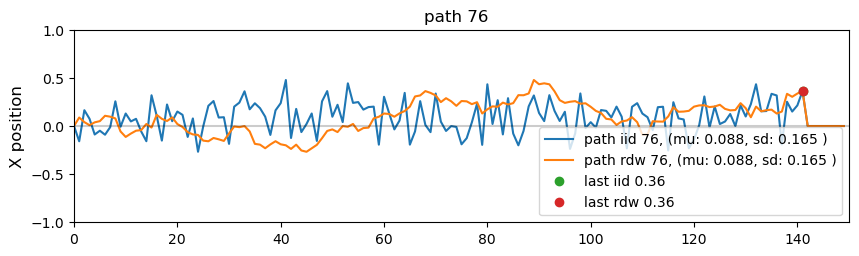

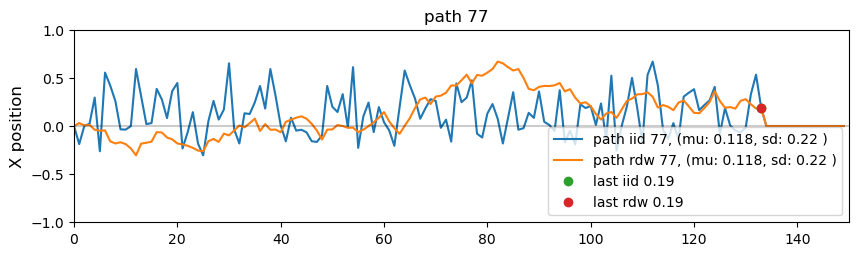

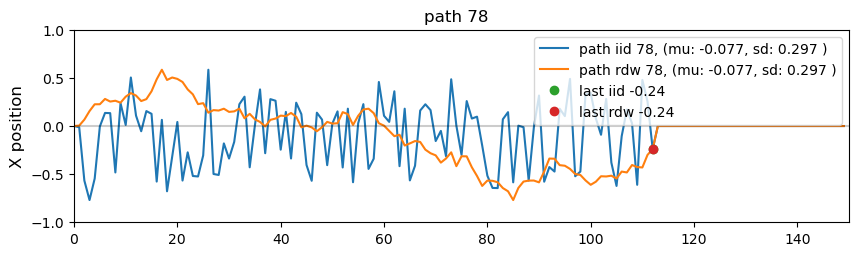

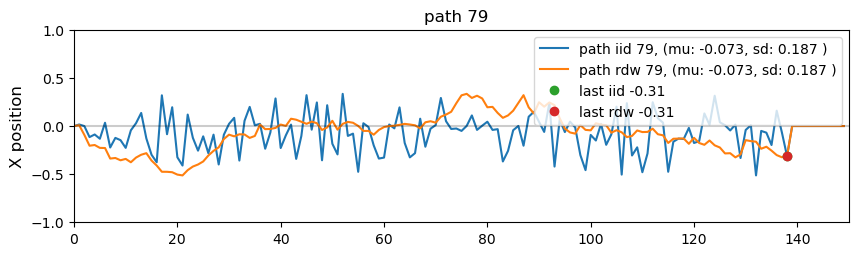

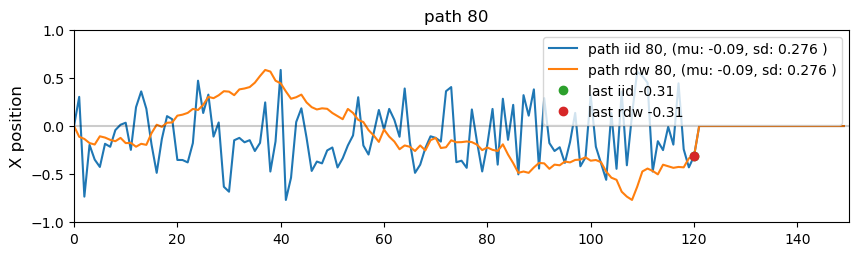

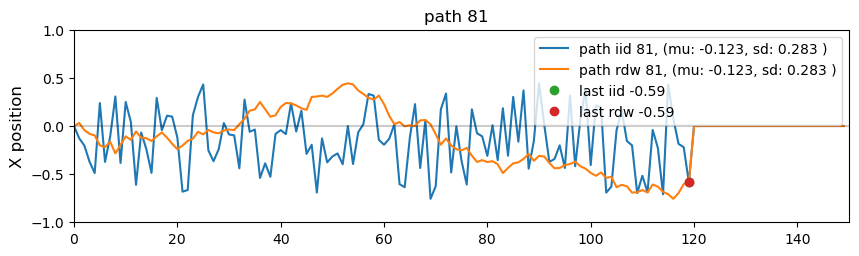

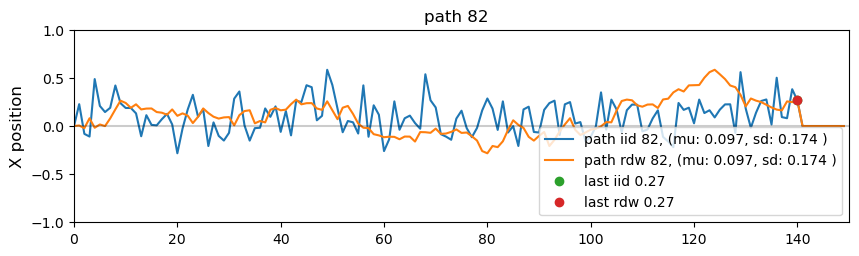

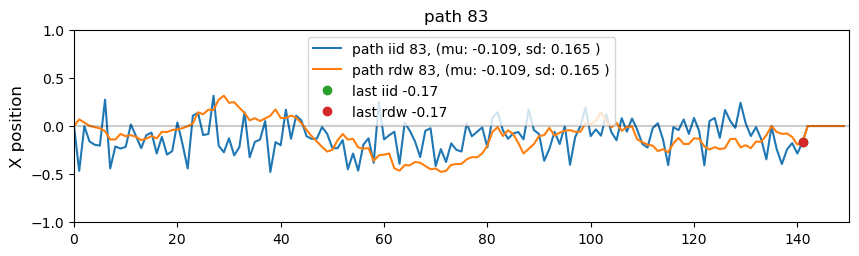

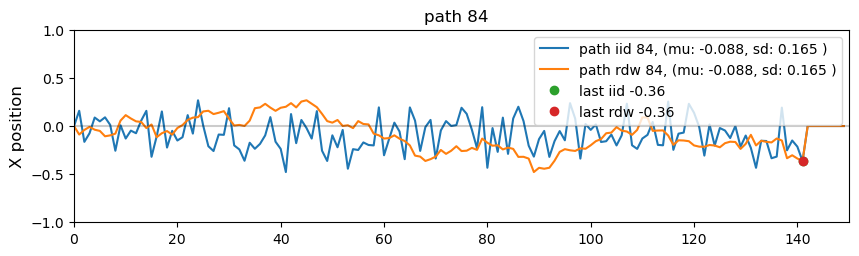

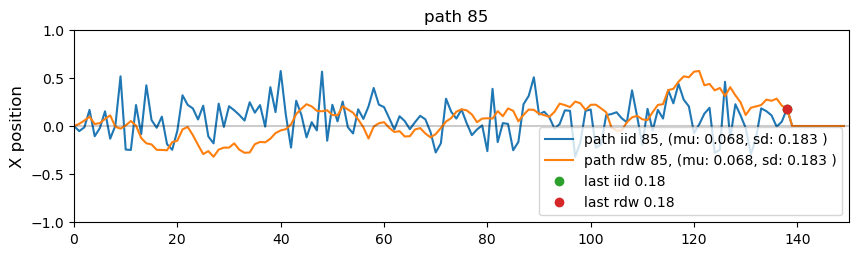

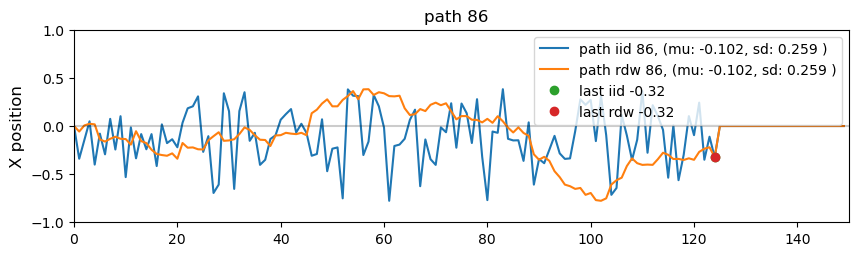

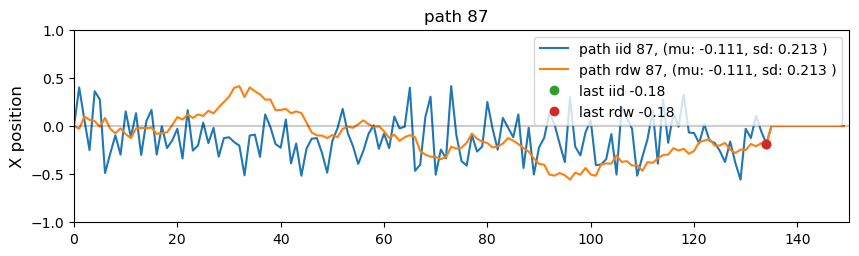

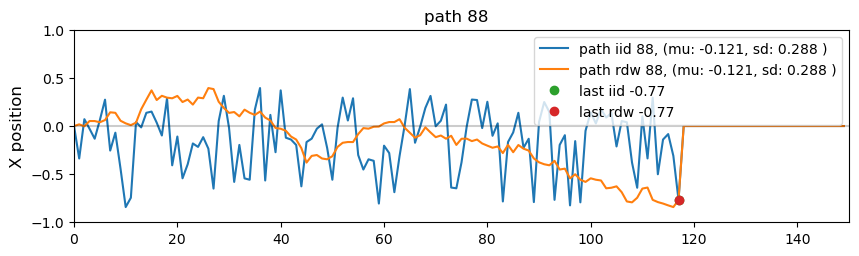

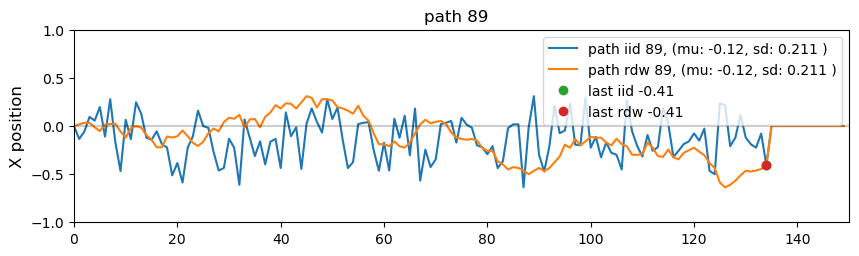

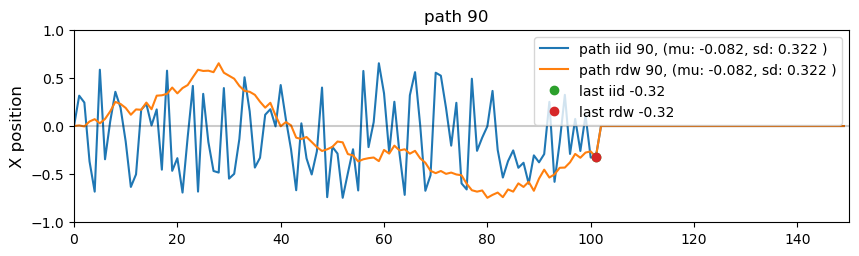

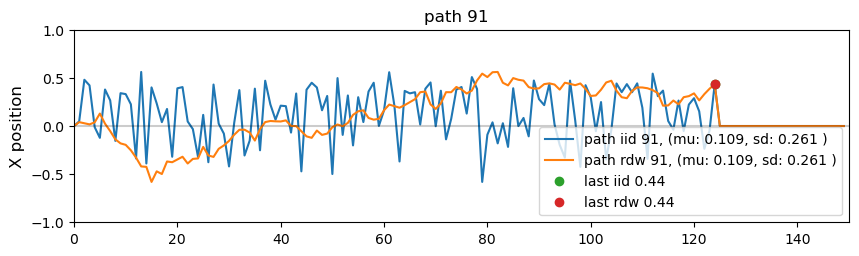

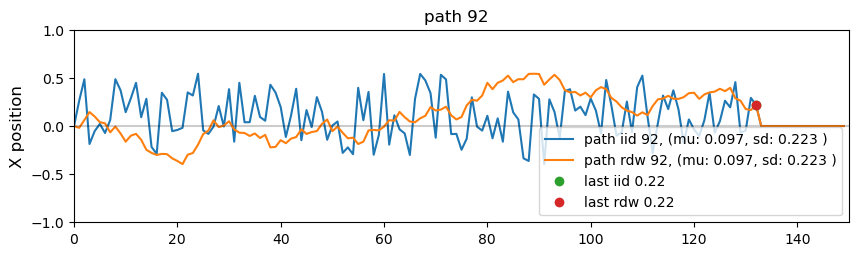

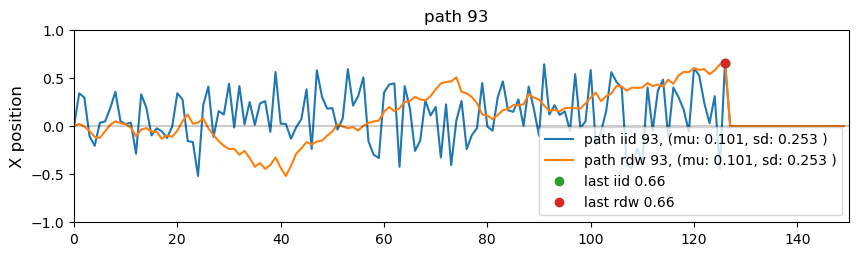

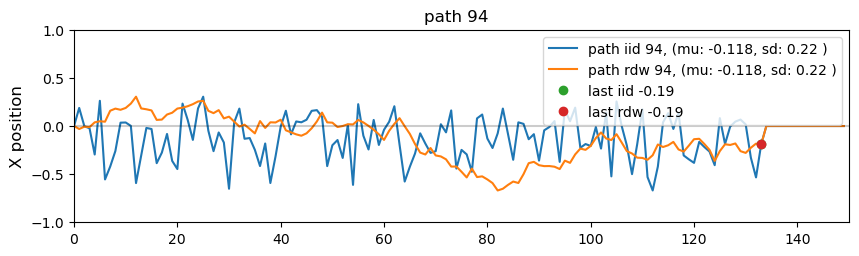

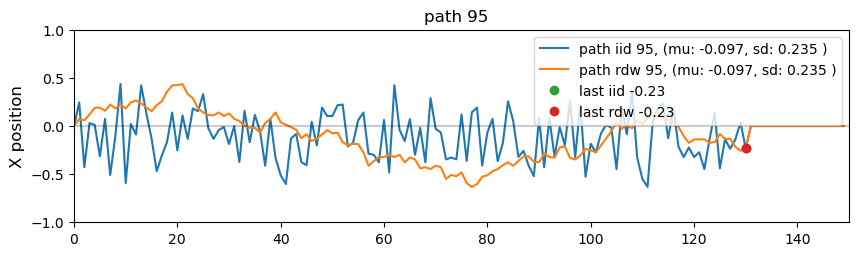

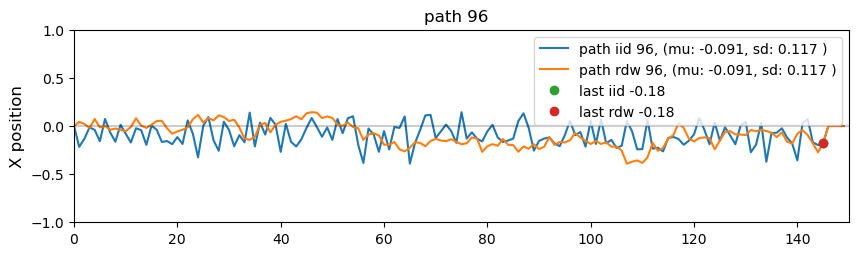

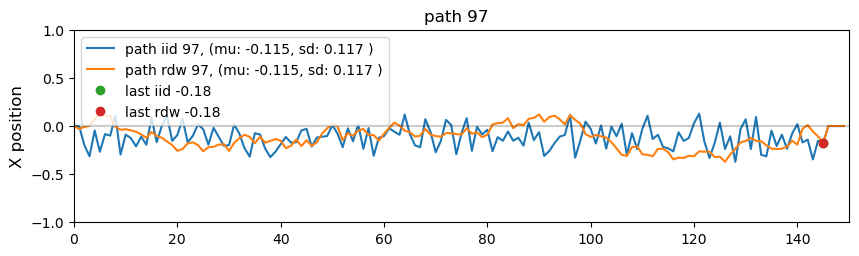

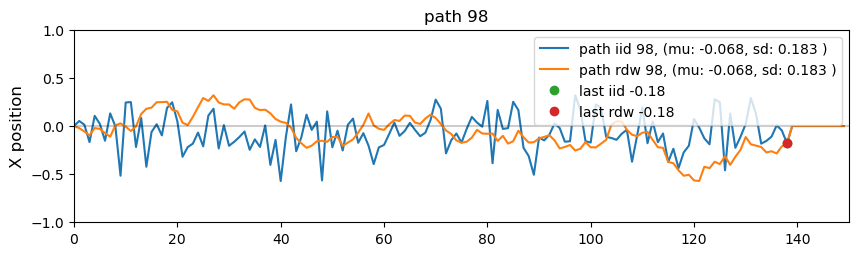

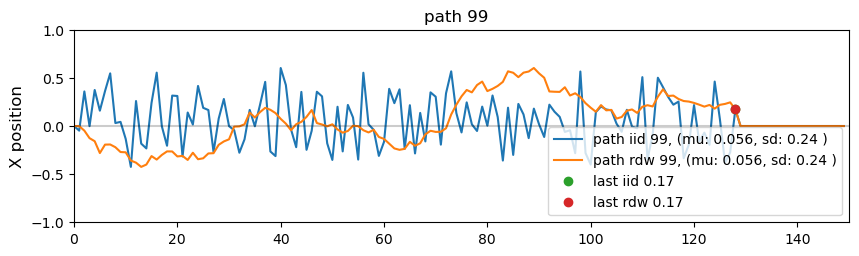

In [36]:
for i in range(len(scaled_list_rdw_same)):
    
    fig = plt.figure(figsize=(10, 5))
    invis = len(np.where(scaled_list_iid_same[i] == 0)[0])
    plt.subplot(2, 1, 1)
    plt.plot(scaled_list_iid_same[i],label=f"path iid {i}, (mu: {round(np.nanmean(scaled_list_iid_same[i]),3)}, sd: {round(np.nanstd(scaled_list_iid_same[i]),3)} )")#
    plt.plot(scaled_list_rdw_same[i],label=f"path rdw {i}, (mu: {round(np.nanmean(scaled_list_rdw_same[i]),3)}, sd: {round(np.nanstd(scaled_list_rdw_same[i]),3)} )")
    plt.plot(len(scaled_list_iid_same[i])-invis, scaled_list_iid_same[i][-invis] ,'o',label=f"last iid {round(scaled_list_iid_same[i][-invis],2)}")
    plt.plot(len(scaled_list_rdw_same[i])-invis, scaled_list_rdw_same[i][-invis] ,'o',label=f"last rdw {round(scaled_list_rdw_same[i][-invis],2)}")
    plt.hlines(0, 0, len(scaled_list_rdw_same[i]),'k',  alpha=0.2)

    plt.subplots_adjust(hspace=0)
    #     plt.title(f"IID path ({mean_side}{lv}{cond})")
#     plt.ylim(-0, 1)
    plt.xlim(0, 150)
    plt.ylabel("X position", fontsize=12)
    plt.legend()

    plt.subplots_adjust(hspace=0)
    plt.title(f"path {i}  ")
#     plt.ylim(-0, 1)
    plt.xlim(0, 150)
    plt.ylim(-1,1)
    plt.ylabel("X position", fontsize=12)

In [12]:
X_iid, all_y_iid, all_rt_iid,all_norm_iid = shuffle_dataset(feature_list_iid, label_list_iid,rt_list_iid,"iid")
X_rdw, all_y_rdw,all_rt_rdw, all_norm_rdw =shuffle_dataset(feature_list_rdw, label_list_rdw,rt_list_rdw,"rdw")

X_iid, all_y_iid, all_rt_iid = remove_nan_indices(X_iid, all_y_iid, all_rt_iid)
X_rdw, all_y_rdw, all_rt_rdw = remove_nan_indices(X_rdw, all_y_rdw, all_rt_rdw)

X_iid_reshaped = X_iid.reshape(X_iid.shape[0], X_iid.shape[1], 1)
X_rdw_reshaped = X_rdw.reshape(X_rdw.shape[0], X_rdw.shape[1], 1)

In [13]:
window_size = 10 


X_iid_recent, y_iid_recent, rt_iid_recent = create_recent_points_data(X_iid_reshaped, all_y_iid, all_rt_iid, window_size)
X_rdw_recent, y_rdw_recent, rt_rdw_recent = create_recent_points_data(X_rdw_reshaped, all_y_rdw, all_rt_rdw, window_size)

print("Shape of X_iid_recent:", X_iid_recent.shape)  #  (path*nsubj, window_size, 1)
print("Shape of y_iid_recent:", y_iid_recent.shape)  # path*nsubj: (5600,)
print("Shape of rt_iid_recent:", rt_iid_recent.shape)  # path*nsubj: (5600,)

Shape of X_iid_recent: (5561, 10, 1)
Shape of y_iid_recent: (5561,)
Shape of rt_iid_recent: (5561,)


In [15]:

X_full_train_iid, X_full_val_iid, X_recent_train_iid, X_recent_val_iid, y_binary_train_iid, y_binary_val_iid, y_time_train_iid, y_time_val_iid = train_test_split(
X_iid_reshaped, X_iid_recent, y_iid_recent, rt_iid_recent, test_size=0.1, random_state=40)


print(f'Training set size: {X_full_train_iid.shape}, {X_recent_train_iid.shape}, {y_binary_train_iid.shape}, {y_time_train_iid.shape}')
print(f'Validation set size: {X_full_val_iid.shape}, {X_recent_val_iid.shape}, {y_binary_val_iid.shape}, {y_time_val_iid.shape}')

X_full_train_rdw, X_full_val_rdw, X_recent_train_rdw, X_recent_val_rdw, y_binary_train_rdw, y_binary_val_rdw, y_time_train_rdw, y_time_val_rdw = train_test_split(
X_rdw_reshaped, X_rdw_recent, y_rdw_recent, rt_rdw_recent, test_size=0.1, random_state=40)


print(f'Training set size: {X_full_train_rdw.shape}, {X_recent_train_rdw.shape}, {y_binary_train_rdw.shape}, {y_time_train_rdw.shape}')
print(f'Validation set size: {X_full_val_rdw.shape}, {X_recent_val_rdw.shape}, {y_binary_val_rdw.shape}, {y_time_val_rdw.shape}')

Training set size: (5004, 150, 1), (5004, 10, 1), (5004,), (5004,)
Validation set size: (557, 150, 1), (557, 10, 1), (557,), (557,)
Training set size: (5006, 150, 1), (5006, 10, 1), (5006,), (5006,)
Validation set size: (557, 150, 1), (557, 10, 1), (557,), (557,)


In [16]:
np.random.seed(42)
X_combined_resent = np.concatenate((X_iid_recent, X_rdw_recent), axis=0)
y_combined_resent = np.concatenate((y_iid_recent, y_rdw_recent), axis=0)
rt_combined = np.concatenate((rt_iid_recent, rt_rdw_recent), axis=0)

X_combined_full = np.concatenate((X_iid_reshaped, X_rdw_reshaped), axis=0)

X_full_train_comb, X_full_val_comb, X_recent_train_comb, X_recent_val_comb, y_binary_train_comb, y_binary_val_comb, y_time_train_comb, y_time_val_comb = train_test_split(
X_combined_full, X_combined_resent, y_combined_resent, rt_combined, test_size=0.1, random_state=42)


print(f'Training set size: {X_full_train_comb.shape}, {X_recent_train_comb.shape}, {y_binary_train_comb.shape}, {y_time_train_comb.shape}')
print(f'Validation set size: {X_full_val_comb.shape}, {X_recent_val_comb.shape}, {y_binary_val_comb.shape}, {y_time_val_comb.shape}')

Training set size: (10011, 150, 1), (10011, 10, 1), (10011,), (10011,)
Validation set size: (1113, 150, 1), (1113, 10, 1), (1113,), (1113,)


In [17]:


def evaluate_model(model, X_full_trajectory, X_recent_trajectory, y_true_binary, y_true_time):

    predictions = model.predict({'full_trajectory': X_full_trajectory, 'recent_trajectory': X_recent_trajectory})

    binary_predictions = predictions[0]  # Binary response predictions
    time_predictions = predictions[1]    # Reaction time predictions

    binary_predictions = (binary_predictions > 0.5).astype(int)

    binary_accuracy = accuracy_score(y_true_binary, binary_predictions)
    precision = precision_score(y_true_binary, binary_predictions)
    recall = recall_score(y_true_binary, binary_predictions)
    f1 = f1_score(y_true_binary, binary_predictions)
    conf_matrix = confusion_matrix(y_true_binary, binary_predictions)


    rmse_time = np.sqrt(mean_squared_error(y_true_time, time_predictions))
    relative_rmse_time = rmse_time / (y_true_time.max() - y_true_time.min())
    metrics = {
        'Binary Accuracy': binary_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': conf_matrix,
        'RMSE for RT Predictions': rmse_time,
        'Relative RMSE for RT Predictions': relative_rmse_time
    }

    return metrics,predictions


def plot_training_history(history):

    rcParams.update({'font.size': 20})  
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Calibri']  
    
    # График точности
    plt.figure(figsize=(27, 9))
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['response_accuracy'])
    plt.plot(history.history['val_response_accuracy'])
    plt.title('Model Accuracy (Response)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 3, 3)
    plt.plot(history.history['reaction_time_mse'])
    plt.plot(history.history['val_reaction_time_mse'])
    plt.title('Mean Squared Error (RT)')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [18]:
def compile_and_fit(model, X_full_train, X_recent_train, y_binary_train, y_time_train, 
                    X_full_val, X_recent_val, y_binary_val, y_time_val, patience=40):
 
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
  
    history = model.fit(
        {'full_trajectory': X_full_train, 'recent_trajectory': X_recent_train}, 
        {'response': y_binary_train, 'reaction_time': y_time_train},  
        epochs=100, batch_size=64, 
        validation_data=(
            {'full_trajectory': X_full_val, 'recent_trajectory': X_recent_val},  
            {'response': y_binary_val, 'reaction_time': y_time_val} 
        ),
        callbacks=[early_stopping]
    )
    
    return history

### One model

In [25]:
#### WORKS ~~~~~~~~~~
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dropout, Flatten, Dense, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
tf.keras.backend.clear_session()
# Full trajectory input
full_trajectory_input = Input(shape=(150, 1), name='full_trajectory')
recent_trajectory_input = Input(shape=(window_size, 1), name='recent_trajectory')

full_lstm_layer = LSTM(64, return_sequences=False)(full_trajectory_input)
full_lstm_layer = Dropout(0.2)(full_lstm_layer)

recent_lstm_layer = LSTM(32, return_sequences=False)(recent_trajectory_input)
recent_lstm_layer = Dropout(0.2)(recent_lstm_layer)

combined_layer = Concatenate()([full_lstm_layer, recent_lstm_layer])
mlp_input = Flatten()(combined_layer)

dense_layer_1 = Dense(32, activation='relu')(mlp_input)
dense_layer_2 = Dense(16, activation='relu')(dense_layer_1)
time_output = Dense(1, name='reaction_time', activation='linear')(dense_layer_2)
response_output = Dense(1, activation='sigmoid', name='response')(mlp_input)

model_combined_full = Model(inputs=[full_trajectory_input, recent_trajectory_input],
                  outputs=[response_output, time_output])

model_combined_full.compile(optimizer=Adam(learning_rate=0.0001),
                       loss={'response': 'binary_crossentropy', 'reaction_time': 'mse'},
                       metrics={'response': 'accuracy', 'reaction_time': 'mse'})

# Summary of the model
model_combined_full.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ recent_trajectory             │ (None, 10, 1)             │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ full_trajectory (InputLayer)  │ (None, 150, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 64)                │          16,896 │ recent_trajectory[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 150)               │               0 │ full_trajectory[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 64)                │               0 │ lstm[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │           9,664 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ response (Dense)              │ (None, 1)                 │              65 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reaction_time (Dense)         │ (None, 1)                 │              65 │ dense[0][0]                │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 26,690 (104.26 KB)

 Trainable params: 26,690 (104.26 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = compile_and_fit(
    model_combined_full, 
    X_full_train_comb, X_recent_train_comb, y_binary_train_comb, y_time_train_comb,  
    X_full_val_comb, X_recent_val_comb, y_binary_val_comb, y_time_val_comb  
)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.1448 - reaction_time_mse: 0.4611 - response_accuracy: 0.7394 - val_loss: 0.9462 - val_reaction_time_mse: 0.2982 - val_response_accuracy: 0.7862
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8951 - reaction_time_mse: 0.2714 - response_accuracy: 0.7932 - val_loss: 0.7805 - val_reaction_time_mse: 0.2638 - val_response_accuracy: 0.7745
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7431 - reaction_time_mse: 0.2450 - response_accuracy: 0.7901 - val_loss: 0.7466 - val_reaction_time_mse: 0.2506 - val_response_accuracy: 0.7844
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7029 - reaction_time_mse: 0.2294 - response_accuracy: 0.7947 - val_loss: 0.7379 - val_reaction_time_mse: 0.2445 - val_response_accuracy: 0.7844
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6665 - reaction_time_mse: 0.2025 - response_accuracy: 0.7964 - val_loss: 0.7280 - val_reaction_time_mse: 0.24

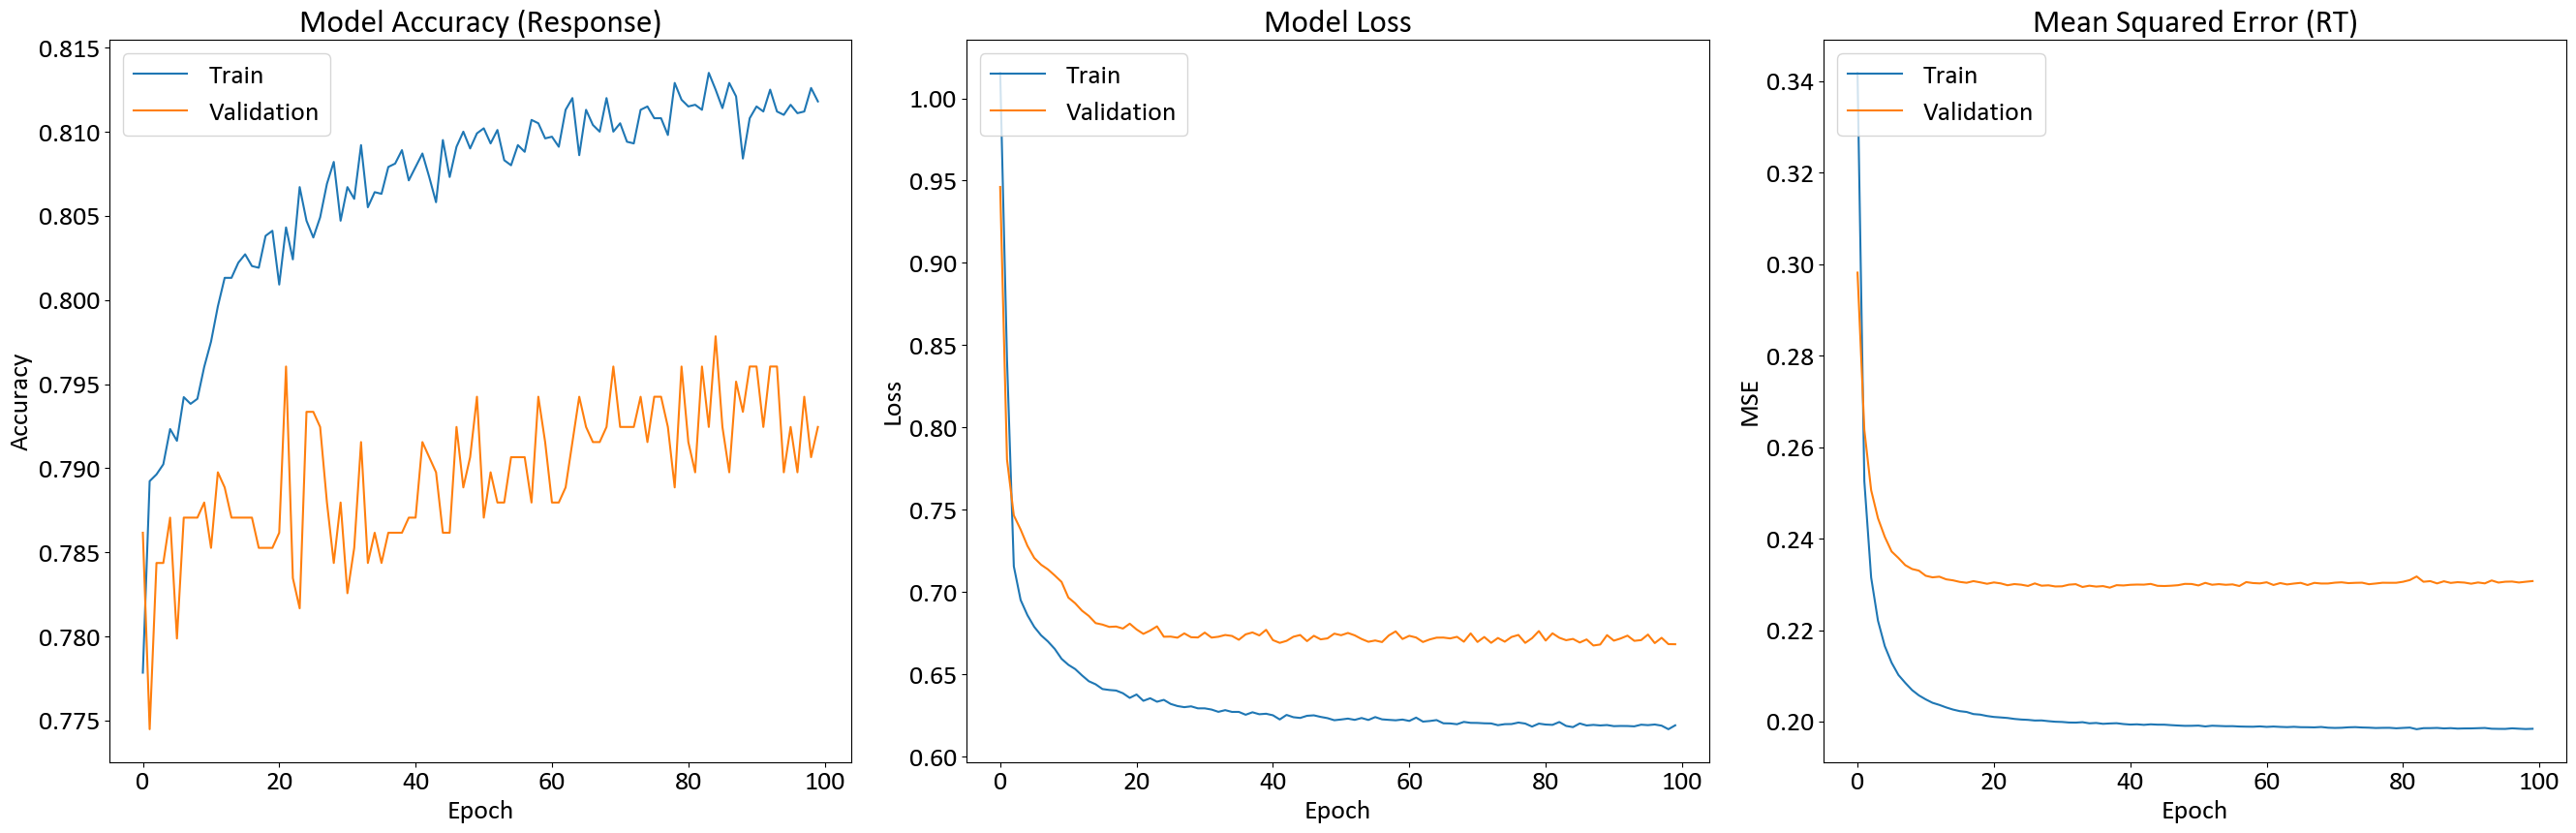

In [27]:
plot_training_history(history)

In [21]:
model_combined_full.save('DUAL_LSTM_MODEL.keras')

In [22]:
train_results = model_combined_full.evaluate(
    {'full_trajectory': X_full_train_comb, 'recent_trajectory': X_recent_train_comb},  
    {'response': y_binary_train_comb, 'reaction_time': y_time_train_comb}, 
    verbose=1
)

val_results = model_combined_full.evaluate(
    {'full_trajectory': X_full_val_comb, 'recent_trajectory': X_recent_val_comb},  
    {'response': y_binary_val_comb, 'reaction_time': y_time_val_comb},  
    verbose=1
)


print(f'Training Loss: {train_results[0]}')
print(f'Training Response prediction Acc: {train_results[2]}')
print(f'Training RT MSE: {train_results[1]}')

print(f'Val Loss: {val_results[0]}')
print(f'Val Response prediction Acc: {val_results[2]}')
print(f'Val RT MSE: {val_results[1]}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.6094 - reaction_time_mse: 0.1912 - response_accuracy: 0.8123
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6621 - reaction_time_mse: 0.2066 - response_accuracy: 0.7769
Training Loss: 0.6149928569793701
Training Response prediction Acc: 0.8140046000480652
Training RT MSE: 0.1972874253988266
Val Loss: 0.6682283282279968
Val Response prediction Acc: 0.7924528121948242
Val RT MSE: 0.2307216078042984


In [23]:
metrics_comb, predictions_comb = evaluate_model(
    model_combined_full, 
    X_full_val_comb,  
    X_recent_val_comb,  
    y_binary_val_comb,  
    y_time_val_comb  
)

for key, value in metrics_comb.items():
    
    print(f"{key}: {value}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Binary Accuracy: 0.7924528301886793
Precision: 0.7650862068965517
Recall: 0.7442348008385744
F1 Score: 0.7545164718384697
Confusion Matrix: [[527 109]
 [122 355]]
RMSE for RT Predictions: 0.4803349090359744
Relative RMSE for RT Predictions: 0.06518318754728925


In [24]:
metrics_comb, predictions_comb = evaluate_model(
    model_combined_full, 
    X_full_val_rdw,  
    X_recent_val_rdw,  
    y_binary_val_rdw,  
    y_time_val_rdw  
)

for key, value in metrics_comb.items():
    
    print(f"{key}: {value}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Binary Accuracy: 0.9120287253141831
Precision: 0.9051094890510949
Recall: 0.915129151291513
F1 Score: 0.9100917431192661
Confusion Matrix: [[260  26]
 [ 23 248]]
RMSE for RT Predictions: 0.38817651050643204
Relative RMSE for RT Predictions: 0.11353510105482072


In [27]:
metrics_iid, predictions_iid = evaluate_model(
    model_combined_full, 
    X_full_val_iid,  
    X_recent_val_iid,  
    y_binary_val_iid,  
    y_time_val_iid  
)

print('metrics_iid validation')
for key, value in metrics_iid.items():
    
    print(f"{key}: {value}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
metrics_iid validation
Binary Accuracy: 0.7199281867145422
Precision: 0.7312775330396476
Recall: 0.6360153256704981
F1 Score: 0.680327868852459
Confusion Matrix: [[235  61]
 [ 95 166]]
RMSE for RT Predictions: 0.47615620163621436
Relative RMSE for RT Predictions: 0.1021794424112048


### Test on SBPM

In [5]:
from tensorflow.keras.models import load_model

model_combined = load_model('DUAL_LSTM_MODEL.keras')
model_combined_rdw = load_model('DUAL_LSTM_MODEL.keras')

In [30]:
def scaled_data_sim(input_list,global_min, global_max):

    normalized_list = []

    for np_array in input_list:
        output_array = 2 * ((np_array - global_min) / (global_max - global_min)) - 1
        normalized_list.append(output_array)

    return normalized_list

In [31]:
nsmooth = 5
noise = 2
nbias = 3
window_size = 10
n_simulations = 100
indices = np.arange(0, 200)
num_indices = len(indices)

data = loadmat('../data/trajectories.mat')


num_trajectories = len(indices)
rmdl = np.zeros((2, num_trajectories))
nmdl = np.zeros((2, num_trajectories))
rMLP = np.zeros((2, num_trajectories))
avg_rt_mlp = np.zeros((2, num_trajectories))
same = np.zeros((2, num_trajectories), dtype=bool)
accuracy_results = np.zeros((2, num_trajectories, n_simulations))
rt_results = np.zeros((2, num_trajectories, n_simulations))
mpos = np.zeros((2, num_indices))
lpos = np.zeros((2, num_indices))

simulated_data = []

for j in tqdm([0, 1], desc="Generating trajectories"):  # 0 for IID, 1 for RDW
    traind = data['iidind'][2:, ] if j == 0 else data['rdwind'][2:, ]
    condition_type = 'iid' if j == 0 else 'rdw'

    for idx, tidx in enumerate(indices):
        invis = int(traind[0, tidx])
        pos = traind[1:, tidx].copy()
        pos[-invis + 1:] = np.nan
        lastpos = pos[-invis]
        meanpos = np.nanmean(pos)
        same_cond = meanpos * lastpos > 0
        condition = f"{condition_type}_{'same' if same_cond else 'opposite'}"
        nmdl_val = np.sign(meanpos if j == 0 else lastpos)

        
        lpos[j, idx] = lastpos
        mpos[j, idx] = meanpos
        same[j, idx] = same_cond
        nmdl[j, idx] = nmdl_val

        
        for sim_idx in range(n_simulations):
            noisy_pos = pos + np.random.randn(len(pos)) * noise + np.random.randn() * nbias
            noisy_pos = [np.array(col[~np.isnan(col)]) for col in noisy_pos.reshape(len(noisy_pos), 1).T][0]
            noisy_pos = np.pad(noisy_pos, (0, 150 - len(noisy_pos)), mode='constant', constant_values=0)
            simulated_data.append({
                'condition': condition,
                'original_idx': idx,
                'simulation_idx': sim_idx,
                'trajectory': noisy_pos,
                'nmdl': nmdl_val
            })

simulated_df = pd.DataFrame(simulated_data)

simulated_df['trajectory_scaled'] = None
for condition in simulated_df['condition'].unique():
    print(f"Scaling trajectories for condition: {condition}")
    condition_data = simulated_df[simulated_df['condition'] == condition]

    for sim_idx in tqdm(range(n_simulations), desc=f"Scaling for condition {condition}"):        
        sim_data = condition_data[condition_data['simulation_idx'] == sim_idx]
        trajectories = sim_data['trajectory'].tolist()
               
        interpolated_trajectories = list_to_interpolate_preserving_stats(trajectories, output_size=150)
        scaled_trajectories,_,_ = scaled_data2(interpolated_trajectories) 
        for i, idx in enumerate(sim_data.index):
            simulated_df.at[idx, 'trajectory_scaled'] = scaled_trajectories[i]

Generating trajectories: 100%|███████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]


Scaling trajectories for condition: iid_same


Scaling for condition iid_same: 100%|████████████████████████████████████████████████| 100/100 [00:01<00:00, 67.53it/s]


Scaling trajectories for condition: iid_opposite


Scaling for condition iid_opposite: 100%|████████████████████████████████████████████| 100/100 [00:01<00:00, 67.76it/s]


Scaling trajectories for condition: rdw_same


Scaling for condition rdw_same: 100%|████████████████████████████████████████████████| 100/100 [00:01<00:00, 69.20it/s]


Scaling trajectories for condition: rdw_opposite


Scaling for condition rdw_opposite: 100%|████████████████████████████████████████████| 100/100 [00:01<00:00, 67.25it/s]


In [32]:

for j, condition_type in enumerate(['iid', 'rdw']):
    condition_df = simulated_df[simulated_df['condition'].str.startswith(condition_type)]

    for idx in tqdm(range(num_trajectories), desc=f"Processing {condition_type.upper()}"):
        trajectory_df = condition_df[condition_df['original_idx'] == idx]

        resp_mlp_list = []
        rt_mlp_list = []
        resp_rmdl_list = []
        for _, row in trajectory_df.iterrows():
            raw_traj = np.array(row['trajectory'])
            scaled_traj = np.array(row['trajectory_scaled'])
            sim_idx = int(row['simulation_idx'])

            
            scaled_full = scaled_traj.reshape(1, 150, 1) 
            invis = len(np.where(raw_traj == 0)[0])
            trajectory_non_zero = scaled_full[0][:-invis]
           # last point in window_size 
            window = trajectory_non_zero[-window_size:]
            scaled_recent = window.reshape(1, window_size, 1)
            #scaled_recent = scaled_traj[-window_size:].reshape(1, window_size, 1)  # Последние точки
            
            model = model_combined if condition_type == 'iid' else model_combined_rdw
            mpl_p = model.predict({'full_trajectory': scaled_full, 'recent_trajectory': scaled_recent}, verbose=0)

            
            side_pred = (mpl_p[0] >= 0.5).astype(int)[0][0]  
            rt_pred = mpl_p[1][0][0]  

            resp_mlp = -1 if side_pred == 1 else 1  
            resp_mlp_list.append(resp_mlp)
            rt_mlp_list.append(rt_pred)

            segment = np.array(row['trajectory'])[:-invis][-nsmooth-1:]
            resp = np.sign(np.mean(segment))  # Response for the 3-param model   
            resp_rmdl_list.append(resp)
            nmdl_val = row['nmdl']
            accuracy_results[j, idx, sim_idx] = int(np.sign(resp_mlp) == np.sign(nmdl_val))
            rt_results[j, idx, sim_idx] = rt_pred
            

        rmdl[j, idx] = np.sum(np.array(resp_rmdl_list) * nmdl_val > 0) / len(resp_rmdl_list)
        rMLP[j, idx] = np.sum(np.array(resp_mlp_list) * nmdl_val > 0) / len(resp_mlp_list)
        avg_rt_mlp[j, idx] = np.mean(rt_mlp_list)


Processing RDW: 100%|████████████████████████████████████████████████████████████████| 200/200 [22:59<00:00,  6.90s/it]


In [33]:
acc_rdw = pd.read_csv('../data/acc_rdw.csv', header=None).to_numpy()
acc_iid = pd.read_csv('../data/acc_iid.csv', header=None).to_numpy()
norres_iid = acc_iid.mean(axis=1)
norres_rdw = acc_rdw.mean(axis=1)
corrrslt = np.vstack([norres_iid,norres_rdw])

rt_rdw = pd.read_csv('../data/pros_rt_rdw.csv', header=None).to_numpy()
rt_iid = pd.read_csv('../data/pros_rt_iid.csv', header=None).to_numpy()
rt_mean_iid = np.nanmean(rt_iid, axis=1)
rt_mean_rdw = np.nanmean(rt_rdw, axis=1)
mean_rt = np.vstack([rt_mean_iid,rt_mean_rdw])

rms_model_iid =np.sqrt(np.nanmean((corrrslt[0, :] - rmdl[0, :]) ** 2))
rms_model_rdw =np.sqrt(np.nanmean((corrrslt[1, :] - rmdl[1, :]) ** 2))
rms_mlp_iid = np.sqrt(np.nanmean((corrrslt[0, :] - rMLP[0, :]) ** 2))
rms_mlp_rdw= np.sqrt(np.nanmean((corrrslt[1, :] - rMLP[1, :]) ** 2))
rms_model_iid,rms_model_rdw,rms_mlp_iid,rms_mlp_rdw

(0.17594818926639297,
 0.11540359524693487,
 0.14914535438522342,
 0.1251230414839892)

### Save data

In [37]:
# Function to get top simulations based on accuracy
def get_top_simulations(tables, accuracies, top_n):
    sorted_indices = np.argsort(accuracies)[-top_n:][::-1]  # Get indices of top  accuracies
    return [tables[i] for i in sorted_indices]


def save_simulation_tables(tables, condition_name, directory='sim_100'):
    # Create directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)
    
    for i, df in enumerate(tables):
        filename = os.path.join(directory, f"sim_{condition_name}_{i}.csv")
        df.to_csv(filename, index=False, sep='\t')
        
# Function to save DataFrame to CSV with appropriate name
def combine_simulation_tables(tables_dict):
    combined_df = pd.DataFrame()
    for i in range(len(tables_dict['iid_same'])):
        for condition_name, tables in tables_dict.items():
            df = tables[i].copy()  # Get the DataFrame for the current simulation and condition
            df['sim'] = i   # Add simulation number
            df['path'] = range(0, len(df) )  # Add path number
            df['condition'] = condition_name  # Add condition name
            combined_df = pd.concat([combined_df, df], ignore_index=True)
    return combined_df

In [53]:

simulation_tables_iid_same = []
simulation_tables_iid_opposite = []
simulation_tables_rdw_same = []
simulation_tables_rdw_opposite = []

mean_accuracy = {
    'iid_same': [],
    'iid_opposite': [],
    'rdw_same': [],
    'rdw_opposite': []
}

for k in range(n_simulations):
    sim_data_iid_same = {
        '# rt': np.abs(rt_results[0, same[0], k]),
        'acc': accuracy_results[0, same[0], k].astype(int)
    }
    sim_data_iid_opposite = {
        '# rt': np.abs(rt_results[0, ~same[0], k]),
        'acc': accuracy_results[0, ~same[0], k].astype(int)
    }
    sim_data_rdw_same = {
        '# rt': np.abs(rt_results[1, same[1], k]),
        'acc': accuracy_results[1, same[1], k].astype(int)
    }
    sim_data_rdw_opposite = {
        '# rt': np.abs(rt_results[1, ~same[1], k]),
        'acc': accuracy_results[1, ~same[1], k].astype(int)
    }

    df_iid_same = pd.DataFrame(sim_data_iid_same)
    df_iid_opposite = pd.DataFrame(sim_data_iid_opposite)
    df_rdw_same = pd.DataFrame(sim_data_rdw_same)
    df_rdw_opposite = pd.DataFrame(sim_data_rdw_opposite)

    # Add condition column
    df_iid_same['condition'] = 'iid_same'
    df_iid_opposite['condition'] = 'iid_opposite'
    df_rdw_same['condition'] = 'rdw_same'
    df_rdw_opposite['condition'] = 'rdw_opposite'

    simulation_tables_iid_same.append(df_iid_same)
    simulation_tables_iid_opposite.append(df_iid_opposite)
    simulation_tables_rdw_same.append(df_rdw_same)
    simulation_tables_rdw_opposite.append(df_rdw_opposite)

    # Store mean accuracy for each simulation
    mean_accuracy['iid_same'].append(df_iid_same['acc'].mean())
    mean_accuracy['iid_opposite'].append(df_iid_opposite['acc'].mean())
    mean_accuracy['rdw_same'].append(df_rdw_same['acc'].mean())
    mean_accuracy['rdw_opposite'].append(df_rdw_opposite['acc'].mean())


In [54]:
# Function to get top simulations based on accuracy
def get_top_simulations(tables, accuracies):
    sorted_indices = np.argsort(accuracies)[-28:][::-1]  # Get indices of top  accuracies
    return [tables[i] for i in sorted_indices]

# Get top  simulations for each condition
top_simulation_tables_iid_same = get_top_simulations(simulation_tables_iid_same, mean_accuracy['iid_same'])
top_simulation_tables_iid_opposite = get_top_simulations(simulation_tables_iid_opposite, mean_accuracy['iid_opposite'])
top_simulation_tables_rdw_same = get_top_simulations(simulation_tables_rdw_same, mean_accuracy['rdw_same'])
top_simulation_tables_rdw_opposite = get_top_simulations(simulation_tables_rdw_opposite, mean_accuracy['rdw_opposite'])

# Function to save DataFrame to CSV with appropriate name
def save_simulation_tables(tables, condition_name):
    for i, df in enumerate(tables):
        filename = f"sim_{condition_name}_{i}.csv"
        df.to_csv(filename, index=False, sep ='\t')

# Save top simulation tables for each condition
save_simulation_tables(top_simulation_tables_iid_same, 'iid_same')
save_simulation_tables(top_simulation_tables_iid_opposite, 'iid_opposite')
save_simulation_tables(top_simulation_tables_rdw_same, 'rdw_same')
save_simulation_tables(top_simulation_tables_rdw_opposite, 'rdw_opposite')

In [39]:
# Get top  simulations for each condition
top_simulation_tables_iid_same = get_top_simulations(simulation_tables_iid_same, mean_accuracy['iid_same'],100)
top_simulation_tables_iid_opposite = get_top_simulations(simulation_tables_iid_opposite, mean_accuracy['iid_opposite'],100)
top_simulation_tables_rdw_same = get_top_simulations(simulation_tables_rdw_same, mean_accuracy['rdw_same'],100)
top_simulation_tables_rdw_opposite = get_top_simulations(simulation_tables_rdw_opposite, mean_accuracy['rdw_opposite'],100)

# Save top simulation tables for each condition
save_simulation_tables(top_simulation_tables_iid_same, 'iid_same')
save_simulation_tables(top_simulation_tables_iid_opposite, 'iid_opposite')
save_simulation_tables(top_simulation_tables_rdw_same, 'rdw_same')
save_simulation_tables(top_simulation_tables_rdw_opposite, 'rdw_opposite')

# Dictionary to hold all top simulation tables
tables_dict = {
    'iid_same': top_simulation_tables_iid_same,
    'iid_opposite': top_simulation_tables_iid_opposite,
    'rdw_same': top_simulation_tables_rdw_same,
    'rdw_opposite': top_simulation_tables_rdw_opposite
}

# Combine all into one large DataFrame
all_combined_df = combine_simulation_tables(tables_dict)

In [41]:
df_rmdl = pd.DataFrame({
    'rms_RSM_model_iid': rmdl[0, :],
    'rms_RSM_model_rdw': rmdl[1, :],
    'rms_LSTM_model_iid': rMLP[0, :],
    'rms_LSTM_model_rdw': rMLP[1, :],
    'meanRT_LSTM_model_iid': avg_rt_mlp[0, :],
    'meanRT_LSTM_model_rdw': avg_rt_mlp[1, :],
})

df_rmdl.to_csv('../data/obs_rmse_sim_DUAL_LSTM.csv', index=False,)